# These are all of the functions that we have written during our research

## The most important ones are ihara_matrix(), edge_adjacency_nb_matrix(), and show_cospectrality()

In [1]:
"""
from sage.matrix.all import *
from sage.algebras.all import *
from sage.graphs.all import *
from sage.rings.all import *
from sage.modules.all import *
"""
import numpy as np
#from numpy.linalg import inv
import multiprocessing as mp
import os
import sage.parallel.multiprocessing_sage
#import time

In [2]:
""" Returns the volume of G """

def vol(G):
    V = 0
    for v in G.vertices():
        V+=G.degree(v)
    return V

In [3]:
""" Returns the degree matrix D of graph G"""

def deg_matrix(G):
    return diagonal_matrix([G.degree(v) for v in G.vertices()], sparse = False)

In [4]:
""" Returns Ihara Matrix of G """

def ihara_matrix(G):
    A = G.adjacency_matrix(); D=deg_matrix(G); I = identity_matrix(G.order()); Z=matrix.zero(G.order())
    return block_matrix(QQbar, [[A,D-I],[-I,Z]], subdivide = False)

In [5]:
""" Returns the normal transition probabillity matrix P of graph G """

def trans_prob_matrix(G):
    A = G.adjacency_matrix()
    D= diagonal_matrix([G.degree(v) for v in G.vertices()])
    Dinv = D^(-1)
    P = Dinv * A
    return P

In [6]:
def edge_ordering_dictionary(G):
    D=dict()
    i=0
    for u in G.vertices():
        for v in G.neighbors(u):
            D.setdefault((u,v),i)
            i=i+1
    return D

In [7]:
""" Creates probability matrix of the non-backtracking matrix """

def trans_prob_matrix_nb(G):
    L = []
    D=edge_ordering_dictionary(G)
    for a in D.keys():
        i=D[a]
        for b in D.keys():
            j=D[b]
            u=a[0]
            v=a[1]
            x=b[0]
            y=b[1]
            if v==x and y!=u:
                L.append(float(1)/(G.degree(v)-1))
            else: L.append(0)
    P = matrix(vol(G), L)
    return P

In [8]:
""" Creates normal edge adjacency matrix C for any graph G """

def edge_adjacency_matrix(G):
    L = []
    D=edge_ordering_dictionary(G)
    for a in D.keys():
        i=D[a]
        for b in D.keys():
            j=D[b]
            u=a[0]
            v=a[1]
            x=b[0]
            y=b[1]
            if v==x:
                L.append(1)
            else: L.append(0)
    B = matrix(vol(G), L)
    return B

In [9]:
""" Creates non-backtracking matrix B for any graph G """

def edge_adjacency_nb_matrix(G):
    L = []
    D=edge_ordering_dictionary(G)
    for a in D.keys():
        i=D[a]
        for b in D.keys():
            j=D[b]
            u=a[0]
            v=a[1]
            x=b[0]
            y=b[1]
            if v==x and y!=u:
                L.append(1)
            else: L.append(0)
    B = matrix(vol(G), L) 
    return B

In [10]:
""" Uses proposition 5.3 to calculate eigenvalues of Ihara Matrix from A """
def compute_K_evals(G):
    K = ihara_matrix(G)
    for A_evec in G.eigenvectors():
        print("lambda: " + str(A_evec[0]))
        for K_evec in K.eigenvectors_right():
            mu = K_evec[0]
            print("Actual mu: " + str(mu))
            G1 = A_evec
            lam = G1[0]
            x_vectors = G1[1]
            for A_evec_same_eval in x_vectors:
                x = list(A_evec_same_eval)
                x = vector(x)
                B_evec = K_evec[1]
                for K_evec_same_eval in B_evec:
                    evec_list = list(K_evec_same_eval)
                    evec_half = evec_list[G.order():]
                    y = vector(evec_half)
                    D = deg_matrix(G)
                    if x*y != 0:
                        mu1_calculated = (lam + sqrt(lam^2 - 4/(x*y)*x*(D - identity_matrix(len(y)))*y)) / 2
                        mu2_calculated = (lam - sqrt(lam^2 - 4/(x*y)*x*(D - identity_matrix(len(y)))*y)) / 2
                        if mu == mu1_calculated or mu == mu2_calculated:
                            print("CORRECT")
                        else:
                            print("INCORRECT")
                    else: 
                        print("x and y are orthogonal")
        print()

In [11]:
""" Tries to find all eigenvalues of Ihara Matrix using Proposition 5.3. If not all are found, 
it prints off the graph of G and a list of eigenvalues that weren't calculated. """

#Takes a long time

def find_eigenvalues(G):    
    K = ihara_matrix(G)
    set_of_evals = list(K.eigenvalues())
    for A_evec in G.eigenvectors():
        for K_evec in K.eigenvectors_right():
            mu = K_evec[0]
            lam = A_evec[0]
            x_vectors = A_evec[1]
            for A_evec_same_eval in x_vectors:
                x = list(A_evec_same_eval)
                x = vector(x)
                K_evectors = K_evec[1]
                for K_evec_same_eval in K_evectors:
                    evec_list = list(K_evec_same_eval)
                    evec_half = evec_list[G.order():]
                    y = vector(evec_half)
                    D = deg_matrix(G)
                    if x*y != 0:
                        mu1_calculated = (lam + sqrt(lam^2 - 4/(x*y)*x*(D - identity_matrix(len(y)))*y)) / 2
                        mu2_calculated = (lam - sqrt(lam^2 - 4/(x*y)*x*(D - identity_matrix(len(y)))*y)) / 2
                        if mu == mu1_calculated or mu == mu2_calculated:
                            if mu in set_of_evals:
                                set_of_evals.remove(mu)
    if len(set_of_evals) == 0:
        print("All eigenvalues found")
    else:
        print("These eigenvalues were not found: " + str(set_of_evals))
        show(G)

In [12]:
""" Returns list of eigenvectors corresponding to jth eigenvalue """

def get_ihara_evec(G,j):
    K = ihara_matrix(G)
    K_i = K.eigenvectors_right()[j]
    K_i_evec = K_i[1]
    return K_i_evec

In [13]:
""" Tells you if the Ihara matrix is diagonalizable """

def is_it_diagonalizable(list_of_graphs):
    for g in list_of_graphs:
        k = ihara_matrix(g)
        if k.is_diagonalizable() == False:
            print("not diagonalizable")
        else:
            print("diagonalizable")

In [14]:
""" Checks if two graphs are adjacency cospectral """
def adjancency_cospectral(g1,g2):
    return g1.spectrum() == g2.spectrum()

In [15]:
""" Checks if two graphs are laplacian cospectral """
def laplacian_cospectral(g1,g2):
    return g1.kirchhoff_matrix().eigenvalues() == g2.kirchhoff_matrix().eigenvalues()

In [16]:
""" Checks if two graphs are signless cospectral """
def signless_cospectral(g1,g2):
    return g1.kirchhoff_matrix(signless=True).eigenvalues() == g2.kirchhoff_matrix(signless=True).eigenvalues()

In [17]:
""" Checks if two graphs are normalized laplacian cospectral """
def normalized_cospectral(g1,g2):
    # TAKES TOO LONG TO RUN THIS 
    return g1.kirchhoff_matrix(normalized=True).eigenvalues() == g2.kirchhoff_matrix(normalized=True).eigenvalues()

In [18]:
""" Checks if two graphs are ihara cospectral """
def ihara_cospectral(g1,g2):
    return ihara_matrix(g1).eigenvalues() == ihara_matrix(g2).eigenvalues()

In [19]:
""" Checks if two graphs are nonbacktracking cospectral """
def nonbactracking_cospectral(g1,g2):
    return edge_adjacency_nb_matrix(g1).eigenvalues() == edge_adjacency_nb_matrix(g2).eigenvalues()

In [20]:
""" Shows cospectrality in regards to relevant matrices and Ihara matrix """

def show_cospectrality(g1,g2):
    print("Cospectrality")
    print("\tAdjacency: " + str(adjancency_cospectral(g1,g2)))
    print("\tLaplacian: " + str(laplacian_cospectral(g1,g2)))
    print("\tSignless: " + str(signless_cospectral(g1,g2)))
    print("\tIhara: " + str(ihara_cospectral(g1,g2)))
    print("\tNonbacktracking: " + str(nonbactracking_cospectral(g1,g2)))
    

In [21]:
def special_GM_switch(g1,g2,C):
    AG = block_matrix(QQbar, [[g1.adjacency_matrix(),C],[C.transpose(),g2.adjacency_matrix()]], subdivide = false)
    b = C.nrows()

    ''''
    for row in range(b):
        count = 0
        for col in range(C.ncols()):
            if C[row,col] == 1:
                count += 1
        if count == b/2:
            for col in range(b):
                if C[row,col] == 1:
                    C[row,col] = 0
                else:
                    C[row,col] = 1
    '''
    for col in range(C.ncols()):
        for row in range(b):
            count = 0
            if C[row,col] == 1:
                count += 1
        if count == b/2:
            for row in range(b):
                if C[row,col] == 1:
                    C[row,col] = 0
                else:
                    C[row,col] = 1  
    
    AH = block_matrix(QQbar, [[g1.adjacency_matrix(),C],[C.transpose(),g2.adjacency_matrix()]], subdivide = false)
    G = Graph(AG)
    H = Graph(AH)
    print("graphs one and two are isomorphic: " + str(G.is_isomorphic(H)))
    return G,H

In [22]:
def GM_switch(g1,g2,C):
    if g1.is_regular() != True:
        print("Graph 1 is not regular")
        return
    else:
        J = ones_matrix(g1.order(), g2.order())
        AG = block_matrix(QQbar, [[g1.adjacency_matrix(),C],[C.transpose(),g2.adjacency_matrix()]], subdivide = false)
        AH = block_matrix(QQbar, [[g1.adjacency_matrix(),J - C],[J.transpose() - C.transpose(),g2.adjacency_matrix()]], subdivide = false)
        G = Graph(AG)
        H = Graph(AH)
        print("graphs one and two are isomorphic: " + str(G.is_isomorphic(H)))
        return G,H

# This is where we've ran a lot of tests. It is a little bit of a mess

In [ ]:
#@parallel(p_iter = 'reference', ncpus = 2)
def make_list(n):
    #print(n, os.getpid())
    return n*n

In [ ]:
def print_graph(G):
    print(os.getpid())
    show(G)


def find_spec(Graph_List):
    spec_set = set()
    spec_dict = {}

    for G in Graph_List:
        spectrum = str(edge_adjacency_nb_matrix(G).eigenvalues())
        if spectrum in spec_dict:
            spec_set.add(spectrum)
            spec_dict[spectrum].append(G)
        else:
            spec_dict.update({spectrum: [G]})
    return spec_set, spec_dict

def find_cospec(spec_set,spec_dict):
    for cospectrum in spec_set:
        print("Graphs corresponding to " + str(cospectrum))
        print(spec_dict[spectrum])
        for G in spec_dict[cospectrum]:
            G.show()
            print(G.to_dictionary())
            

if __name__ == '__main__':
    p = mp.Pool()
    foo = p.map(make_list, range(10))
    print(foo)

    '''
    Graph_List = graphs.nauty_geng("4")
    from sage.parallel.multiprocessing_sage import pyprocessing 
    p_iter = pyprocessing(8)
    P = parallel(p_iter=p_iter)
    def f(x): return x+x
    %timeit G_list = list(P(print_graph)(Graph_List))
    print(G_list[0::3])
    Graphs = graphs.nauty_geng("4")
    print(time())
    for G in Graphs:
        print_graph(G)
    print(time())
    '''


In [ ]:
'''
Most optimal way to find cospectral graphs
'''

Graph_List = graphs.nauty_geng("7 -d2")
spec_set = set()
spec_dict = {}

for G in Graph_List:
    spectrum = str(ihara_matrix(G).eigenvalues())
    if spectrum in spec_dict:
        spec_set.add(spectrum)
        spec_dict[spectrum].append(G)
    else:
        spec_dict.update({spectrum: [G]})


for cospectrum in spec_set:
    print("Graphs corresponding to " + str(cospectrum))
    print(spec_dict[spectrum])
    for G in spec_dict[cospectrum]:
        G.show()
        print(G.to_dictionary())

Graphs corresponding to ('[-1, -2.899690153936827?, -1.848525627880367?, -1.187465765016797?, -0.6238667826517779?, 0.4527465019050228?, 0.5533412332224887?, 1.635027444593824?, 4.918433149764433?]', '[0, 2.174562238269810?, 3.6590306987403?, 3.8681457109328?, 4.6734597645144?, 6.106342157748?, 7.6451083906018?, 5.689886719089? + 0.?e-44*I, 8.1834643201050? + 0.?e-31*I]')
[Graph on 9 vertices]


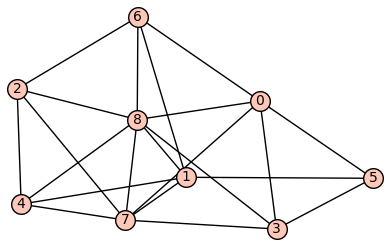

{0: [3, 5, 6, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 6, 7, 8], 3: [0, 5, 7, 8], 4: [1, 2, 7, 8], 5: [0, 1, 3], 6: [0, 1, 2, 8], 7: [0, 1, 2, 3, 4, 8], 8: [0, 1, 2, 3, 4, 6, 7]}


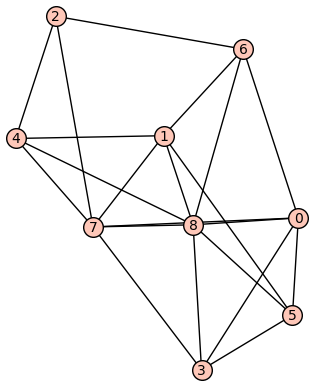

{0: [3, 5, 6, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 6, 7], 3: [0, 5, 7, 8], 4: [1, 2, 7, 8], 5: [0, 1, 3, 8], 6: [0, 1, 2, 8], 7: [0, 1, 2, 3, 4, 8], 8: [0, 1, 3, 4, 5, 6, 7]}
Graphs corresponding to ('[-1, -2.424737666073648?, -2.151799680337785?, -1.222605777001044?, -0.8718568854487951?, 0.4506743601969201?, 0.8114990132390067?, 2.013334264319141?, 4.395492371106205?]', '[5, 0, 1.819491968103082?, 2.700473881891115?, 3.83895119407487?, 4.83977875195425?, 5.7744884814258?, 6.50577203041056?, 7.52104369214040?]')
[Graph on 9 vertices]


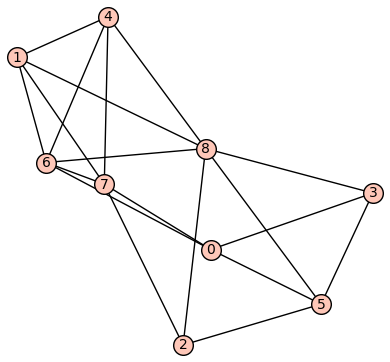

{0: [3, 5, 6, 7], 1: [4, 6, 7, 8], 2: [5, 7, 8], 3: [0, 5, 8], 4: [1, 6, 7, 8], 5: [0, 2, 3, 8], 6: [0, 1, 4, 7, 8], 7: [0, 1, 2, 4, 6], 8: [1, 2, 3, 4, 5, 6]}


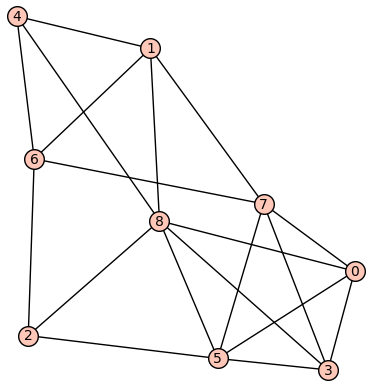

{0: [3, 5, 7, 8], 1: [4, 6, 7, 8], 2: [5, 6, 8], 3: [0, 5, 7, 8], 4: [1, 6, 8], 5: [0, 2, 3, 7, 8], 6: [1, 2, 4, 7], 7: [0, 1, 3, 5, 6], 8: [0, 1, 2, 3, 4, 5]}
Graphs corresponding to ('[-2.544979295552872?, -1.577302168073932?, -1.173372918205322?, -0.1896763205019929?, 0.1815468220307832?, 0.7066659823282332?, 1.914524758575752?, 4.644819163682836?, -1.962226024283486? + 0.?e-66*I]', '[0, 2.039271806598875?, 3.22030513008570?, 3.9046309836706?, 4.4002662235279?, 5.419805447149?, 6.217345217534?, 6.5816019368321?, 8.21677325460247?]')
[Graph on 9 vertices]


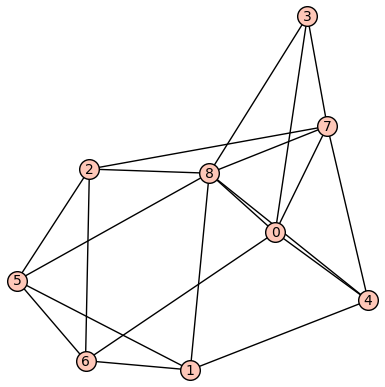

{0: [3, 4, 6, 7, 8], 1: [4, 5, 6, 8], 2: [5, 6, 7, 8], 3: [0, 7, 8], 4: [0, 1, 7, 8], 5: [1, 2, 6, 8], 6: [0, 1, 2, 5], 7: [0, 2, 3, 4, 8], 8: [0, 1, 2, 3, 4, 5, 7]}


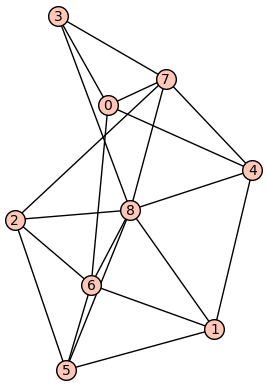

{0: [3, 4, 6, 7], 1: [4, 5, 6, 8], 2: [5, 6, 7, 8], 3: [0, 7, 8], 4: [0, 1, 7, 8], 5: [1, 2, 6, 8], 6: [0, 1, 2, 5, 8], 7: [0, 2, 3, 4, 8], 8: [1, 2, 3, 4, 5, 6, 7]}
Graphs corresponding to ('[0, -1, -2.375343498097565?, -1.589295875255127?, -1.383227349864610?, 0.1968060863830683?, 0.5131686613278073?, 2.217457703917635?, 3.420434271588790?]', '[4, 0, 0.5755063683468195?, 1.234573343789502?, 2.782028465617072?, 3.255701186184815?, 4.77086815298716?, 5.31856258760896?, 6.062759895465680?]')
[Graph on 9 vertices]


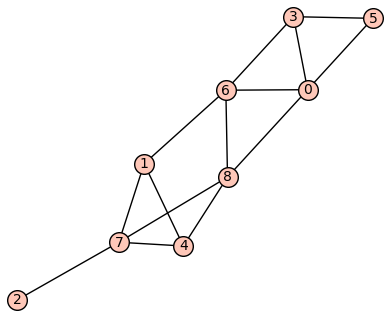

{0: [3, 5, 6, 8], 1: [4, 6, 7], 2: [7], 3: [0, 5, 6], 4: [1, 7, 8], 5: [0, 3], 6: [0, 1, 3, 8], 7: [1, 2, 4, 8], 8: [0, 4, 6, 7]}


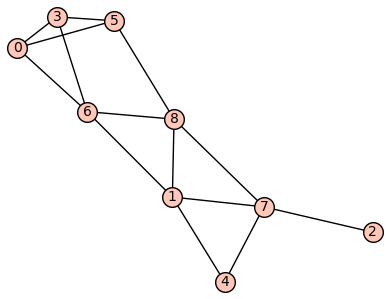

{0: [3, 5, 6], 1: [4, 6, 7, 8], 2: [7], 3: [0, 5, 6], 4: [1, 7], 5: [0, 3, 8], 6: [0, 1, 3, 8], 7: [1, 2, 4, 8], 8: [1, 5, 6, 7]}
Graphs corresponding to ('[-2.959621280347619?, -1.719095104519794?, -1.545874482498342?, -0.8097380229676046?, -0.6157991197769603?, 0.3623546628218618?, 0.8119962716409012?, 1.353444515364654?, 5.122332560282902?]', '[0, 2.475215576599760?, 3.7209786334923?, 4.4252562240057?, 4.695125792169?, 6.066400309141?, 6.743724407063?, 7.671428930003?, 8.2018701275274?]')
[Graph on 9 vertices]


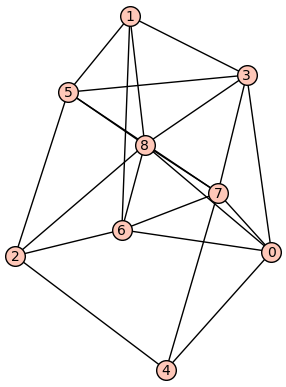

{0: [3, 4, 6, 7, 8], 1: [3, 5, 6, 8], 2: [4, 5, 6, 8], 3: [0, 1, 5, 7, 8], 4: [0, 2, 7], 5: [1, 2, 3, 7, 8], 6: [0, 1, 2, 7, 8], 7: [0, 3, 4, 5, 6, 8], 8: [0, 1, 2, 3, 5, 6, 7]}


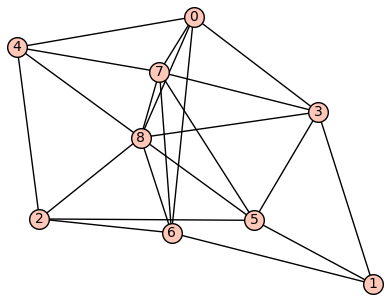

{0: [3, 4, 6, 7, 8], 1: [3, 5, 6], 2: [4, 5, 6, 8], 3: [0, 1, 5, 7, 8], 4: [0, 2, 7, 8], 5: [1, 2, 3, 7, 8], 6: [0, 1, 2, 7, 8], 7: [0, 3, 4, 5, 6, 8], 8: [0, 2, 3, 4, 5, 6, 7]}
Graphs corresponding to ('[-1, -2.244635716554916?, -1.901796270015310?, -1.587590915822590?, -0.5237703576262120?, -0.1584363540577570?, 0.7151263526294667?, 2.218937539041034?, 4.482165722406283?]', '[5, 0, 1.449832880373000?, 3.148300721310778?, 3.82985454135889?, 4.31039385111431?, 5.81947701706837?, 6.33088082204707?, 8.11126016672760?]')
[Graph on 9 vertices]


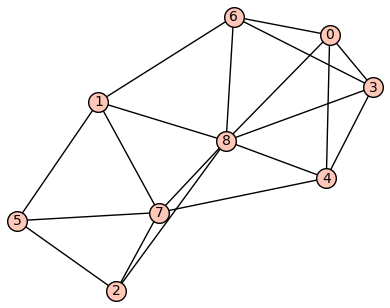

{0: [3, 4, 6, 8], 1: [5, 6, 7, 8], 2: [5, 7, 8], 3: [0, 4, 6, 8], 4: [0, 3, 7, 8], 5: [1, 2, 7], 6: [0, 1, 3, 8], 7: [1, 2, 4, 5, 8], 8: [0, 1, 2, 3, 4, 6, 7]}


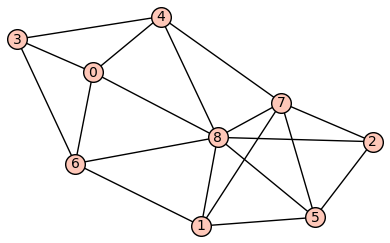

{0: [3, 4, 6, 8], 1: [5, 6, 7, 8], 2: [5, 7, 8], 3: [0, 4, 6], 4: [0, 3, 7, 8], 5: [1, 2, 7, 8], 6: [0, 1, 3, 8], 7: [1, 2, 4, 5, 8], 8: [0, 1, 2, 4, 5, 6, 7]}
Graphs corresponding to ('[-1, -1, -2.532976742531827?, -1.814124083657903?, -1.394012846253578?, -0.3095652424309913?, 0.935985234789918?, 1.548817684716979?, 5.565875995367402?]', '[7, 0, 2.548962169613366?, 3.798605441190957?, 5.4339865381962?, 6.2278247016319?, 6.6543918090377?, 8.0227642825410?, 8.3134650577889?]')
[Graph on 9 vertices]


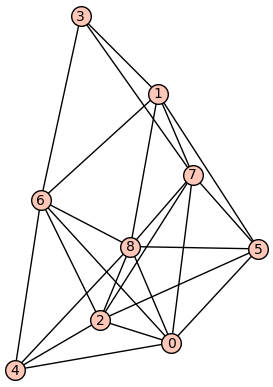

{0: [2, 4, 5, 6, 7, 8], 1: [3, 5, 6, 7, 8], 2: [0, 4, 5, 6, 7, 8], 3: [1, 6, 7], 4: [0, 2, 6, 8], 5: [0, 1, 2, 7, 8], 6: [0, 1, 2, 3, 4, 8], 7: [0, 1, 2, 3, 5, 8], 8: [0, 1, 2, 4, 5, 6, 7]}


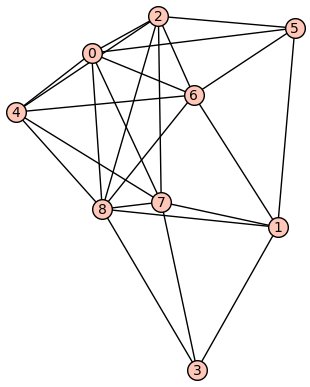

{0: [2, 4, 5, 6, 7, 8], 1: [3, 5, 6, 7, 8], 2: [0, 4, 5, 6, 7, 8], 3: [1, 7, 8], 4: [0, 2, 6, 7, 8], 5: [0, 1, 2, 6], 6: [0, 1, 2, 4, 5, 8], 7: [0, 1, 2, 3, 4, 8], 8: [0, 1, 2, 3, 4, 6, 7]}
Graphs corresponding to ('[0, -1, -3.218239562451129?, -1.815501276349517?, -1.231001394039332?, 0.2897422945017958?, 0.5593779274644912?, 1.356518531790427?, 5.059103479083263?]', '[5, 0, 2.937240104534320?, 3.68143741239105?, 4.22913184701284?, 5.7442988138152?, 6.2179715343830?, 7.7654266562105?, 8.42449363165318?]')
[Graph on 9 vertices]


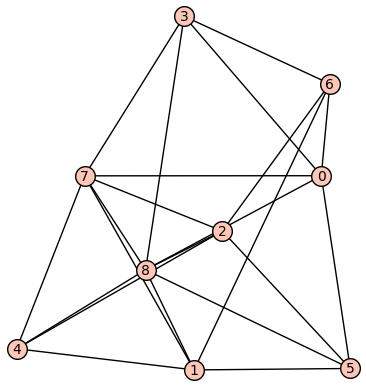

{0: [3, 5, 6, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 5, 6, 7, 8], 3: [0, 6, 7, 8], 4: [1, 2, 7, 8], 5: [0, 1, 2, 8], 6: [0, 1, 2, 3], 7: [0, 1, 2, 3, 4, 8], 8: [0, 1, 2, 3, 4, 5, 7]}


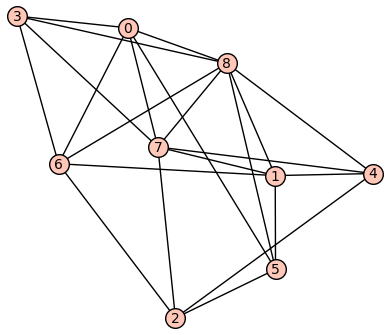

{0: [3, 5, 6, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 5, 6, 7], 3: [0, 6, 7, 8], 4: [1, 2, 7, 8], 5: [0, 1, 2, 8], 6: [0, 1, 2, 3, 8], 7: [0, 1, 2, 3, 4, 8], 8: [0, 1, 3, 4, 5, 6, 7]}
Graphs corresponding to ('[-2.927361430718785?, -1.787665088871194?, -1.524058623567204?, -0.6131117543639159?, -0.1949564336623590?, 0.5334573504593890?, 0.7308620506362011?, 1.165320263200570?, 4.617513666887297?]', '[0, 3.3286884273955?, 3.5915341860573?, 4.4626485780700?, 4.9690296371549?, 6.3156951019336?, 6.7568703323653?, 7.6863722391772?, 0.8891614978463460? + 0.?e-59*I]')
[Graph on 9 vertices]


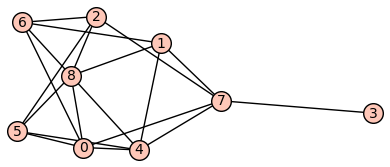

{0: [4, 5, 6, 7, 8], 1: [4, 6, 7, 8], 2: [5, 6, 7, 8], 3: [7], 4: [0, 1, 5, 7, 8], 5: [0, 2, 4, 8], 6: [0, 1, 2, 8], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 4, 5, 6]}


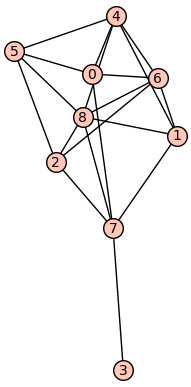

{0: [4, 5, 6, 7], 1: [4, 6, 7, 8], 2: [5, 6, 7, 8], 3: [7], 4: [0, 1, 5, 6, 8], 5: [0, 2, 4, 8], 6: [0, 1, 2, 4, 8], 7: [0, 1, 2, 3, 8], 8: [1, 2, 4, 5, 6, 7]}
Graphs corresponding to ('[-1, -2, -2.433118166334355?, -1.527139278387264?, -0.5889521895871387?, 0.1948403253580463?, 0.2601092345511773?, 1.658872326564508?, 5.435387747835026?]', '[8, 0, 2.219536953812193?, 4.0928364948654?, 4.3904662440165?, 4.7376883424557?, 6.9426194912562?, 7.3301718716835?, 8.28668060191061?]')
[Graph on 9 vertices]


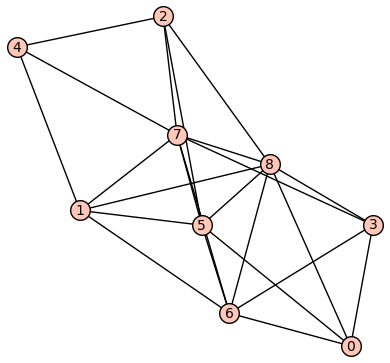

{0: [3, 5, 6, 8], 1: [4, 5, 6, 7, 8], 2: [4, 5, 7, 8], 3: [0, 6, 7, 8], 4: [1, 2, 7], 5: [0, 1, 2, 6, 7, 8], 6: [0, 1, 3, 5, 7, 8], 7: [1, 2, 3, 4, 5, 6, 8], 8: [0, 1, 2, 3, 5, 6, 7]}


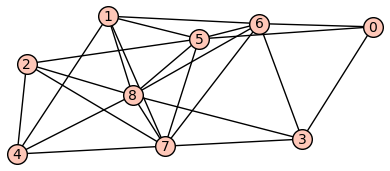

{0: [3, 5, 6], 1: [4, 5, 6, 7, 8], 2: [4, 5, 7, 8], 3: [0, 6, 7, 8], 4: [1, 2, 7, 8], 5: [0, 1, 2, 6, 7, 8], 6: [0, 1, 3, 5, 7, 8], 7: [1, 2, 3, 4, 5, 6, 8], 8: [1, 2, 3, 4, 5, 6, 7]}
Graphs corresponding to ('[0, -2, -2.800116151656589?, -1.235474711427652?, -1.071128989221338?, 0.5242217152754539?, 0.6829792553183746?, 1.315408824356155?, 4.584110057355594?]', '[0, 1.752382668927040?, 2.63900539791337?, 2.92716551290488?, 4.35671796421294?, 5.4084410150614?, 5.6599112044123?, 7.0153344894694?, 8.24104174709878? + 0.?e-59*I]')
[Graph on 9 vertices]


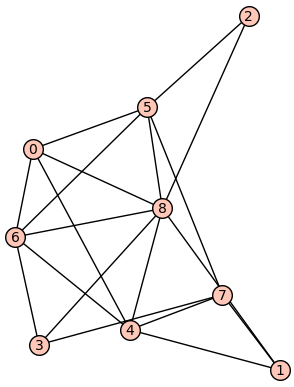

{0: [4, 5, 6, 8], 1: [4, 7, 8], 2: [5, 8], 3: [6, 7, 8], 4: [0, 1, 6, 7, 8], 5: [0, 2, 6, 7, 8], 6: [0, 3, 4, 5, 8], 7: [1, 3, 4, 5], 8: [0, 1, 2, 3, 4, 5, 6]}


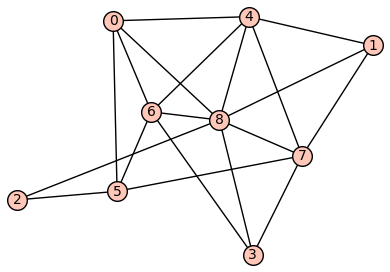

{0: [4, 5, 6, 8], 1: [4, 7, 8], 2: [5, 8], 3: [6, 7, 8], 4: [0, 1, 6, 7, 8], 5: [0, 2, 6, 7], 6: [0, 3, 4, 5, 8], 7: [1, 3, 4, 5, 8], 8: [0, 1, 2, 3, 4, 6, 7]}
Graphs corresponding to ('[0, -1, -2.432957823115254?, -1.985973330737810?, -0.673961048120419?, 0.1871428936333679?, 0.8401319680354626?, 1.787382966072207?, 3.278234374232446?]', '[4, 0, 0.6865349422110930?, 0.9772357174589962?, 2.345608190962301?, 2.772175298368136?, 3.566013461803797?, 5.201394558809044?, 6.451037830386634?]')
[Graph on 9 vertices]


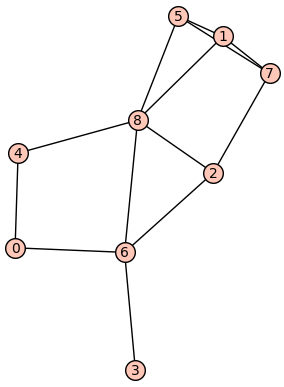

{0: [4, 6], 1: [5, 7, 8], 2: [6, 7, 8], 3: [6], 4: [0, 8], 5: [1, 7, 8], 6: [0, 2, 3, 8], 7: [1, 2, 5], 8: [1, 2, 4, 5, 6]}


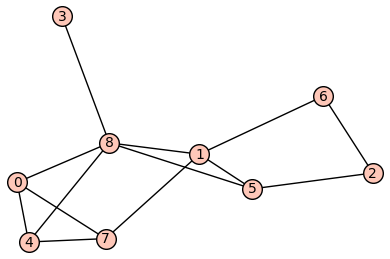

{0: [4, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6], 3: [8], 4: [0, 7, 8], 5: [1, 2, 8], 6: [1, 2], 7: [0, 1, 4], 8: [0, 1, 3, 4, 5]}
Graphs corresponding to ('[0, -1.414213562373095?, 1.414213562373095?, -3.190800446118678?, -1.234320404794243?, -0.6952537985714561?, 0.5186738224831978?, 0.7268396095052047?, 3.874861217495974?]', '[4, 0, 0.879949715317243?, 2.133225387023903?, 2.686735493072399?, 4.56186452659156?, 4.8437631734953?, 5.43474150103472?, 7.459720203464870?]')
[Graph on 9 vertices]


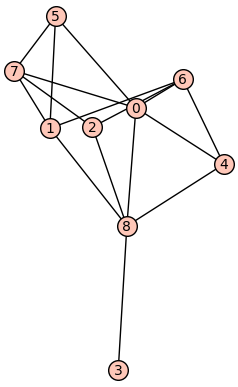

{0: [4, 5, 6, 7, 8], 1: [5, 6, 7, 8], 2: [6, 7, 8], 3: [8], 4: [0, 6, 8], 5: [0, 1, 7], 6: [0, 1, 2, 4], 7: [0, 1, 2, 5], 8: [0, 1, 2, 3, 4]}


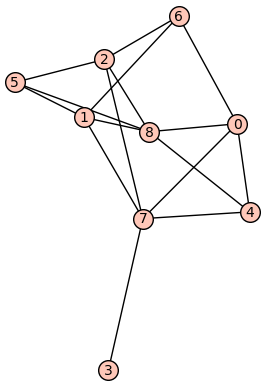

{0: [4, 6, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6, 7, 8], 3: [7], 4: [0, 7, 8], 5: [1, 2, 8], 6: [0, 1, 2], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 4, 5]}
Graphs corresponding to ('[-2.842235679324305?, -1.506941916150187?, 0.5069419161501871?, 1.842235679324306?, -1.947723751879583?, -0.5945469252633153?, -0.4647130112734642?, 0.9063091481549951?, 4.100674540261367?]', '[6, 5, 4, 3, 0, 1.777450154695349?, 3.457060720927810?, 7.222549845304651?, 5.542939279072190? + 0.?e-83*I]')
[Graph on 9 vertices]


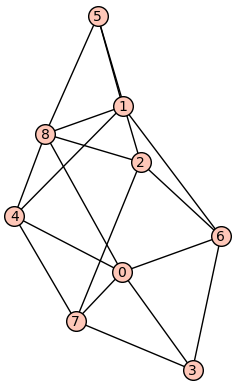

{0: [3, 4, 6, 7, 8], 1: [4, 5, 6, 8], 2: [5, 6, 7, 8], 3: [0, 6, 7], 4: [0, 1, 7, 8], 5: [1, 2, 8], 6: [0, 1, 2, 3], 7: [0, 2, 3, 4], 8: [0, 1, 2, 4, 5]}


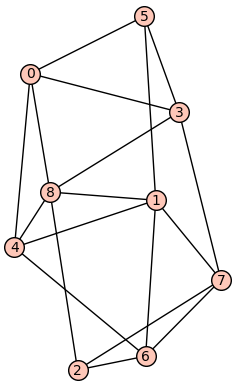

{0: [3, 4, 5, 8], 1: [4, 5, 6, 7, 8], 2: [6, 7, 8], 3: [0, 5, 7, 8], 4: [0, 1, 6, 8], 5: [0, 1, 3], 6: [1, 2, 4, 7], 7: [1, 2, 3, 6], 8: [0, 1, 2, 3, 4]}
Graphs corresponding to ('[0, -2.669616632299786?, -1.899503063465701?, -1.664408823440099?, -0.8248563989612689?, 0.4913332664516952?, 0.702885069311603?, 1.538399380570033?, 4.325767201833524?]', '[0, 2.300371851724682?, 4.239123278256554?, 6.460504870018764?, 1.715274622715598?, 2.925627377032361?, 4.543599454262634?, 5.600033443478754?, 8.215465102510655? + 0.?e-83*I]')
[Graph on 9 vertices]


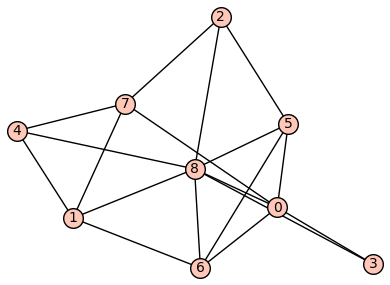

{0: [3, 5, 6, 7, 8], 1: [4, 6, 7, 8], 2: [5, 7, 8], 3: [0, 8], 4: [1, 7, 8], 5: [0, 2, 6, 8], 6: [0, 1, 5, 8], 7: [0, 1, 2, 4], 8: [0, 1, 2, 3, 4, 5, 6]}


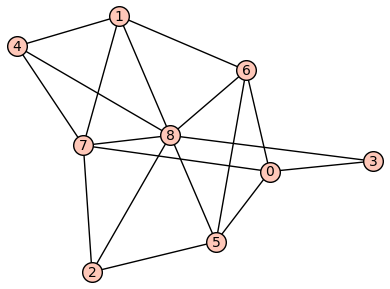

{0: [3, 5, 6, 7], 1: [4, 6, 7, 8], 2: [5, 7, 8], 3: [0, 8], 4: [1, 7, 8], 5: [0, 2, 6, 8], 6: [0, 1, 5, 8], 7: [0, 1, 2, 4, 8], 8: [1, 2, 3, 4, 5, 6, 7]}
Graphs corresponding to ('[-1, -2, -2.470889675689952?, -1.186847439201653?, -0.5902526716778173?, 0.5280933720038211?, 0.5742715830565648?, 1.722872342137251?, 4.422752489371785?]', '[0, 1.394008152081759?, 2.46295320290806?, 2.76500706205905?, 4.14947225049867?, 4.8393391535600?, 5.6293360592729?, 6.64119269175196?, 8.11869142786762?]')
[Graph on 9 vertices]


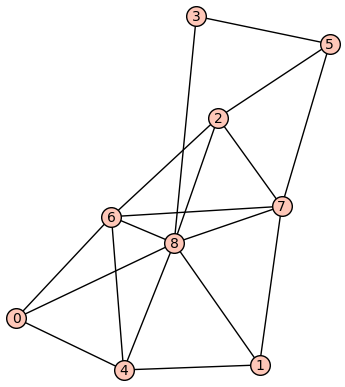

{0: [4, 6, 8], 1: [4, 7, 8], 2: [5, 6, 7, 8], 3: [5, 8], 4: [0, 1, 6, 8], 5: [2, 3, 7], 6: [0, 2, 4, 7, 8], 7: [1, 2, 5, 6, 8], 8: [0, 1, 2, 3, 4, 6, 7]}


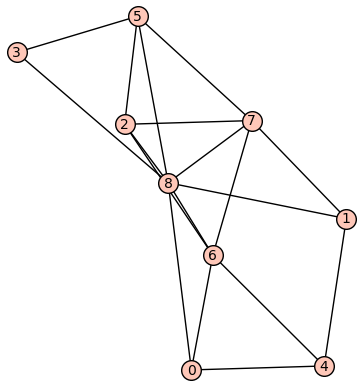

{0: [4, 6, 8], 1: [4, 7, 8], 2: [5, 6, 7, 8], 3: [5, 8], 4: [0, 1, 6], 5: [2, 3, 7, 8], 6: [0, 2, 4, 7, 8], 7: [1, 2, 5, 6, 8], 8: [0, 1, 2, 3, 5, 6, 7]}
Graphs corresponding to ('[-1, -2.427449882549391?, -1.856189539885264?, -1.519677665918374?, -0.540806954354467?, 0.1980757592197639?, 0.2678377822809630?, 2.155692971540452?, 4.722517529666316?]', '[5, 0, 1.540279796535130?, 3.56525849896529?, 4.1562368265047?, 4.4381354734085?, 6.31326450692760?, 6.8667746129761?, 8.12005028468276?]')
[Graph on 9 vertices]


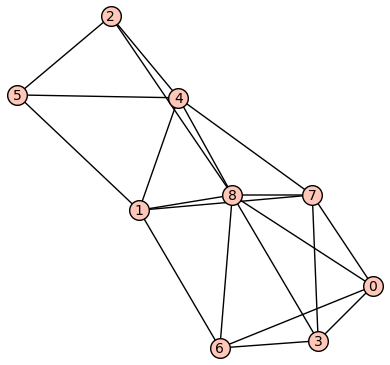

{0: [3, 6, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 5, 8], 3: [0, 6, 7, 8], 4: [1, 2, 5, 7, 8], 5: [1, 2, 4], 6: [0, 1, 3, 8], 7: [0, 1, 3, 4, 8], 8: [0, 1, 2, 3, 4, 6, 7]}


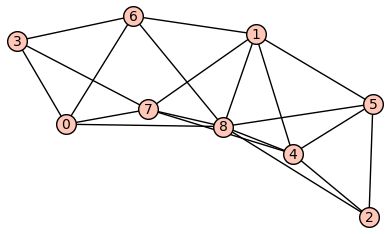

{0: [3, 6, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 5, 8], 3: [0, 6, 7], 4: [1, 2, 5, 7, 8], 5: [1, 2, 4, 8], 6: [0, 1, 3, 8], 7: [0, 1, 3, 4, 8], 8: [0, 1, 2, 4, 5, 6, 7]}
Graphs corresponding to ('[0, -2.734584431658845?, -1.842242383892285?, -1.542332630737654?, -1.182641311900058?, 0.1831594382832267?, 0.3951267646216205?, 1.852077834654397?, 4.871436720629596?]', '[0, 2.102455964094468?, 3.8146612654740?, 4.242804302277?, 4.449309193708?, 5.685199170672?, 6.321026004666?, 7.1393978461780?, 8.2451462529313?]')
[Graph on 9 vertices]


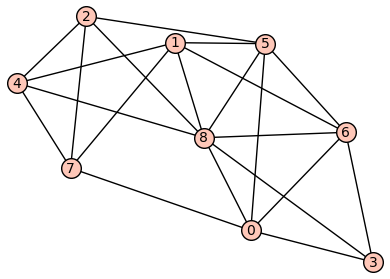

{0: [3, 5, 6, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 5, 7, 8], 3: [0, 6, 8], 4: [1, 2, 7, 8], 5: [0, 1, 2, 6, 8], 6: [0, 1, 3, 5, 8], 7: [0, 1, 2, 4], 8: [0, 1, 2, 3, 4, 5, 6]}


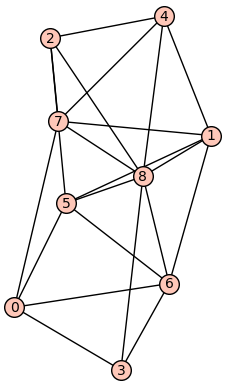

{0: [3, 5, 6, 7], 1: [4, 5, 6, 7, 8], 2: [4, 5, 7, 8], 3: [0, 6, 8], 4: [1, 2, 7, 8], 5: [0, 1, 2, 6, 8], 6: [0, 1, 3, 5, 8], 7: [0, 1, 2, 4, 8], 8: [1, 2, 3, 4, 5, 6, 7]}
Graphs corresponding to ('[0, -1.414213562373095?, 1.414213562373095?, -2.695258252010014?, -1.249132443759812?, -0.8066833662981105?, 0.5249718513081943?, 0.8248454449947791?, 3.401256765764962?]', '[1, 0, 0.7133193980893879?, 1.669828128316533?, 2.057380508743799?, 4.26231165754432?, 4.60953375598352?, 4.90716350513463?, 6.780463046187808?]')
[Graph on 9 vertices]


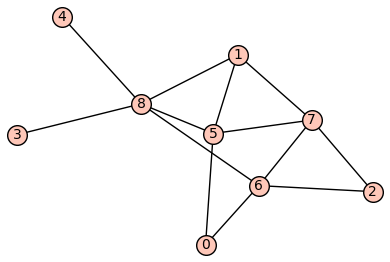

{0: [5, 6], 1: [5, 7, 8], 2: [6, 7], 3: [8], 4: [8], 5: [0, 1, 7, 8], 6: [0, 2, 7, 8], 7: [1, 2, 5, 6], 8: [1, 3, 4, 5, 6]}


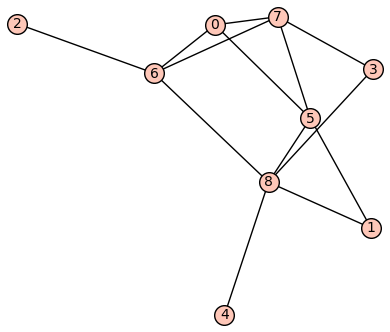

{0: [5, 6, 7], 1: [5, 8], 2: [6], 3: [7, 8], 4: [8], 5: [0, 1, 7, 8], 6: [0, 2, 7, 8], 7: [0, 3, 5, 6], 8: [1, 3, 4, 5, 6]}
Graphs corresponding to ('[0, -1, -2, -2.827861932630834?, -1.545800935526675?, 0.1681101250662512?, 0.3873464137869058?, 1.265341362959188?, 5.552864966345164?]', '[8, 0, 3.098537575391832?, 4.2909134131847?, 4.399033661410?, 5.2103838046237?, 7.1087792022518?, 7.3676620476517?, 8.52469029548632?]')
[Graph on 9 vertices]


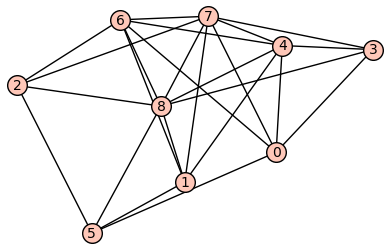

{0: [3, 4, 5, 6, 7], 1: [4, 5, 6, 7, 8], 2: [5, 6, 7, 8], 3: [0, 4, 7, 8], 4: [0, 1, 3, 6, 7, 8], 5: [0, 1, 2, 8], 6: [0, 1, 2, 4, 7, 8], 7: [0, 1, 2, 3, 4, 6, 8], 8: [1, 2, 3, 4, 5, 6, 7]}


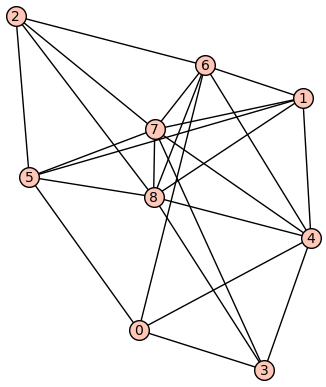

{0: [3, 4, 5, 6], 1: [4, 5, 6, 7, 8], 2: [5, 6, 7, 8], 3: [0, 4, 7, 8], 4: [0, 1, 3, 6, 7, 8], 5: [0, 1, 2, 7, 8], 6: [0, 1, 2, 4, 7, 8], 7: [1, 2, 3, 4, 5, 6, 8], 8: [1, 2, 3, 4, 5, 6, 7]}
Graphs corresponding to ('[-1, -2.567335418931984?, -1.718818208600397?, -0.1967175451143759?, 0.2901919104698049?, 0.7185842026032839?, 1.583729454018089?, 4.455986247738814?, -1.565620642183236? + 0.?e-70*I]', '[0, 2.539495129981237?, 4.760876721743446?, 6.699628148275318?, 0.7845348974893450?, 3.399966556521247?, 6.074372622967639?, 7.284725377284403?, 4.456400545737366? + 0.?e-48*I]')
[Graph on 9 vertices]


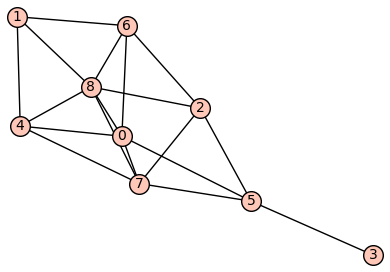

{0: [4, 5, 6, 7, 8], 1: [4, 6, 8], 2: [5, 6, 7, 8], 3: [5], 4: [0, 1, 7, 8], 5: [0, 2, 3, 7], 6: [0, 1, 2, 8], 7: [0, 2, 4, 5, 8], 8: [0, 1, 2, 4, 6, 7]}


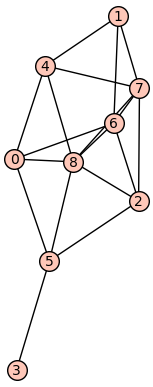

{0: [4, 5, 6, 8], 1: [4, 6, 7], 2: [5, 6, 7, 8], 3: [5], 4: [0, 1, 7, 8], 5: [0, 2, 3, 8], 6: [0, 1, 2, 7, 8], 7: [1, 2, 4, 6, 8], 8: [0, 2, 4, 5, 6, 7]}
Graphs corresponding to ('[-1, -2.959793174387442?, -1.835698397740458?, -1.647262194347547?, -0.2092943821381879?, 0.2738847629647373?, 0.7254598052378280?, 0.9407678338906206?, 5.711935746520449?]', '[8, 0, 3.76854661121616?, 4.3902233708929?, 4.7305425071446?, 5.7288016857689?, 7.1131462205121?, 7.6905225804039?, 8.57821702406157?]')
[Graph on 9 vertices]


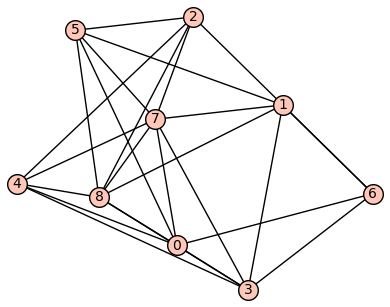

{0: [3, 4, 5, 6, 7, 8], 1: [3, 5, 6, 7, 8], 2: [4, 5, 6, 7, 8], 3: [0, 1, 4, 6, 7, 8], 4: [0, 2, 3, 7, 8], 5: [0, 1, 2, 7, 8], 6: [0, 1, 2, 3], 7: [0, 1, 2, 3, 4, 5, 8], 8: [0, 1, 2, 3, 4, 5, 7]}


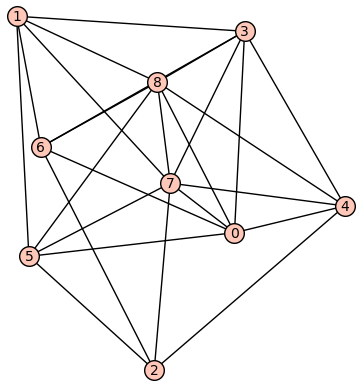

{0: [3, 4, 5, 6, 7, 8], 1: [3, 5, 6, 7, 8], 2: [4, 5, 6, 7], 3: [0, 1, 4, 6, 7, 8], 4: [0, 2, 3, 7, 8], 5: [0, 1, 2, 7, 8], 6: [0, 1, 2, 3, 8], 7: [0, 1, 2, 3, 4, 5, 8], 8: [0, 1, 3, 4, 5, 6, 7]}
Graphs corresponding to ('[0, -3.089186037053969?, -1.814949386488875?, -1.463083991877004?, -0.2030750274765500?, 0.2218169384174776?, 1.138377318606360?, 1.179680584390836?, 4.030419601481724?]', '[4, 0, 1.478956307859600?, 2.494227969589440?, 3.22551151857428?, 4.16022124804575?, 5.16104880592513?, 6.29952611810889?, 7.18050803189692?]')
[Graph on 9 vertices]


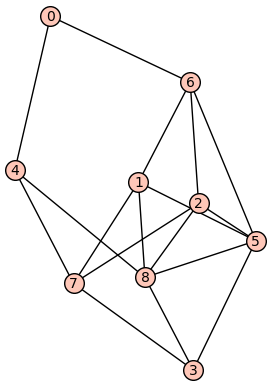

{0: [4, 6], 1: [5, 6, 7, 8], 2: [5, 6, 7, 8], 3: [5, 7, 8], 4: [0, 7, 8], 5: [1, 2, 3, 6, 8], 6: [0, 1, 2, 5], 7: [1, 2, 3, 4], 8: [1, 2, 3, 4, 5]}


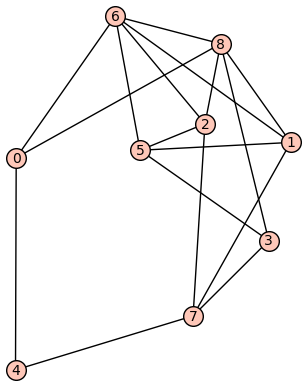

{0: [4, 6, 8], 1: [5, 6, 7, 8], 2: [5, 6, 7, 8], 3: [5, 7, 8], 4: [0, 7], 5: [1, 2, 3, 6], 6: [0, 1, 2, 5, 8], 7: [1, 2, 3, 4], 8: [0, 1, 2, 3, 6]}
Graphs corresponding to ('[0, -2.612788834144786?, -2.171319125289252?, -1.412194729035518?, -0.9643766514265438?, 0.4002511143500482?, 0.7715950621435790?, 1.801569093169774?, 4.187264070232699?]', '[3, 0, 1.819491968103082?, 2.700473881891115?, 3.83895119407487?, 4.83977875195425?, 5.7744884814258?, 6.50577203041056?, 7.52104369214040?]')
[Graph on 9 vertices]


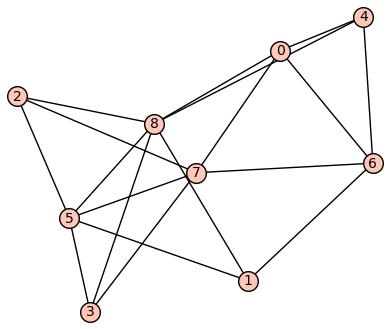

{0: [4, 6, 7, 8], 1: [5, 6, 8], 2: [5, 7, 8], 3: [5, 7, 8], 4: [0, 6, 8], 5: [1, 2, 3, 7, 8], 6: [0, 1, 4, 7], 7: [0, 2, 3, 5, 6], 8: [0, 1, 2, 3, 4, 5]}


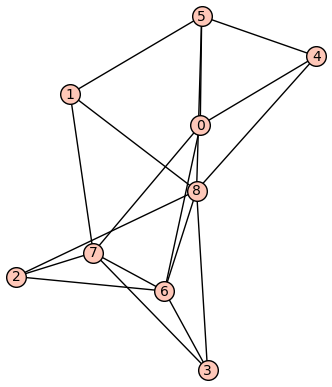

{0: [4, 5, 6, 7], 1: [5, 7, 8], 2: [6, 7, 8], 3: [6, 7, 8], 4: [0, 5, 8], 5: [0, 1, 4, 8], 6: [0, 2, 3, 7, 8], 7: [0, 1, 2, 3, 6], 8: [1, 2, 3, 4, 5, 6]}
Graphs corresponding to ('[0, -2, -1.752764854616334?, -1.433852333629215?, -0.7913206647645428?, 0.4584081110697796?, 0.816079951826460?, 1.959073645755604?, 2.744376144358250?]', '[1, 0, 0.4217829759384257?, 1.309477419596102?, 1.886853779487872?, 3.271198314231133?, 4.26945749285548?, 4.60977662910715?, 5.23145338878385?]')
[Graph on 9 vertices]


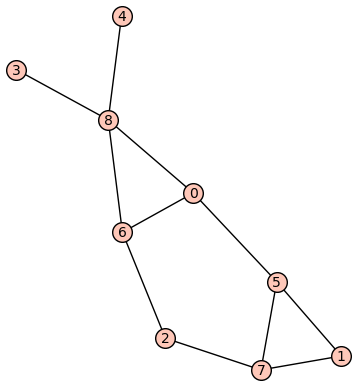

{0: [5, 6, 8], 1: [5, 7], 2: [6, 7], 3: [8], 4: [8], 5: [0, 1, 7], 6: [0, 2, 8], 7: [1, 2, 5], 8: [0, 3, 4, 6]}


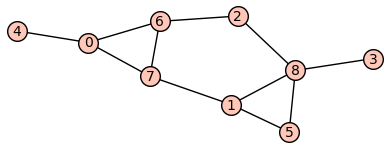

{0: [4, 6, 7], 1: [5, 7, 8], 2: [6, 8], 3: [8], 4: [0], 5: [1, 8], 6: [0, 2, 7], 7: [0, 1, 6], 8: [1, 2, 3, 5]}
Graphs corresponding to ('[-2.382086295678771?, -1.781935903409705?, -1.641210347384594?, -0.8134983065470845?, -0.5802435310487127?, 0.4029538622026326?, 0.7774261402349618?, 1.873552175913232?, 4.145042205718040?]', '[0, 1.313627760822822?, 2.243129667634727?, 2.68430489806642?, 4.0309703628452?, 4.5373514219300?, 5.4084658139427?, 5.6713115726045?, 8.110838502153654?]')
[Graph on 9 vertices]


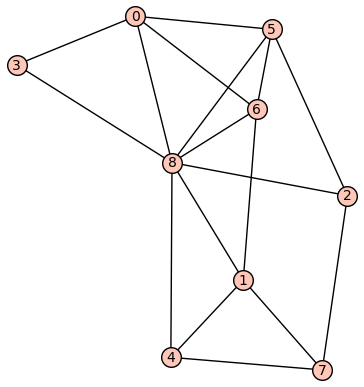

{0: [3, 5, 6, 8], 1: [4, 6, 7, 8], 2: [5, 7, 8], 3: [0, 8], 4: [1, 7, 8], 5: [0, 2, 6, 8], 6: [0, 1, 5, 8], 7: [1, 2, 4], 8: [0, 1, 2, 3, 4, 5, 6]}


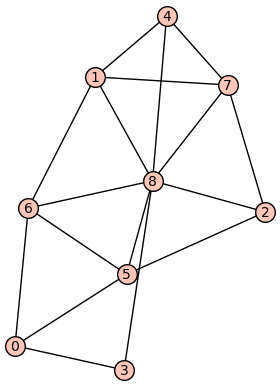

{0: [3, 5, 6], 1: [4, 6, 7, 8], 2: [5, 7, 8], 3: [0, 8], 4: [1, 7, 8], 5: [0, 2, 6, 8], 6: [0, 1, 5, 8], 7: [1, 2, 4, 8], 8: [1, 2, 3, 4, 5, 6, 7]}
Graphs corresponding to ('[0, -1, -2.348931232117543?, -1.859929857555840?, -1.526778358543574?, 0.1993307346897060?, 0.5004016817245813?, 1.755830423154261?, 4.280076608648410?]', '[0, 0.7589582529012229?, 1.984665510530635?, 3.34008879558772?, 3.59155898493864?, 4.64328203578706?, 6.0728344870951?, 6.3609946020867?, 7.24761733107296?]')
[Graph on 9 vertices]


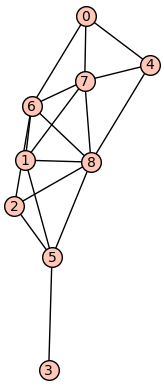

{0: [4, 6, 7], 1: [5, 6, 7, 8], 2: [5, 6, 8], 3: [5], 4: [0, 7, 8], 5: [1, 2, 3, 8], 6: [0, 1, 2, 7, 8], 7: [0, 1, 4, 6, 8], 8: [1, 2, 4, 5, 6, 7]}


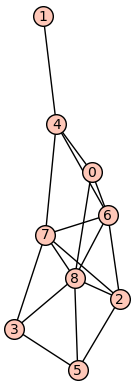

{0: [4, 6, 8], 1: [4], 2: [5, 6, 7, 8], 3: [5, 7, 8], 4: [0, 1, 6, 7], 5: [2, 3, 8], 6: [0, 2, 4, 7, 8], 7: [2, 3, 4, 6, 8], 8: [0, 2, 3, 5, 6, 7]}
Graphs corresponding to ('[-1, -2, -1.893825187800157?, -1.361244340834005?, -0.2129675582541069?, 0.3552295138311647?, 0.722996377470991?, 2.281903969244943?, 3.107907226341169?]', '[4, 0, 1.210743289352743?, 2.206939768257867?, 2.896073664743459?, 4.56404944955221?, 5.15805165441621?, 5.437140810232136?, 0.5270013634453852? + 0.?e-59*I]')
[Graph on 9 vertices]


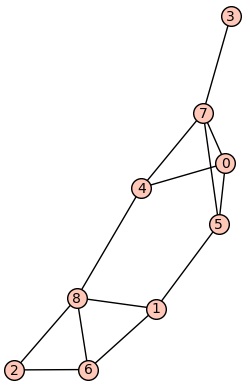

{0: [4, 5, 7], 1: [5, 6, 8], 2: [6, 8], 3: [7], 4: [0, 7, 8], 5: [0, 1, 7], 6: [1, 2, 8], 7: [0, 3, 4, 5], 8: [1, 2, 4, 6]}


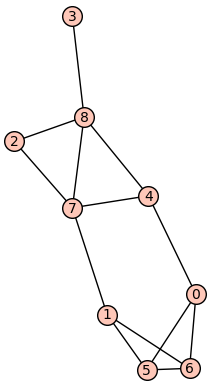

{0: [4, 5, 6], 1: [5, 6, 7], 2: [7, 8], 3: [8], 4: [0, 7, 8], 5: [0, 1, 6], 6: [0, 1, 5], 7: [1, 2, 4, 8], 8: [2, 3, 4, 7]}
Graphs corresponding to ('[-1, -2.598331897855113?, -1.807606865428696?, -1.628019443905176?, -0.580284968600674?, -0.1542806392739802?, 0.7201222061453371?, 1.449147830871847?, 5.599253778046454?]', '[8, 0, 2.499078321050933?, 4.3873179766447?, 4.6075246652965?, 5.5806928911316?, 6.9429560667283?, 7.6679834904682?, 8.31444658867985?]')
[Graph on 9 vertices]


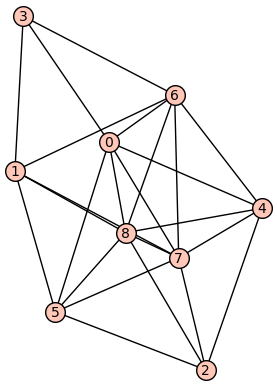

{0: [3, 4, 5, 6, 7, 8], 1: [3, 5, 6, 7, 8], 2: [4, 5, 7, 8], 3: [0, 1, 6], 4: [0, 2, 6, 7, 8], 5: [0, 1, 2, 7, 8], 6: [0, 1, 3, 4, 7, 8], 7: [0, 1, 2, 4, 5, 6, 8], 8: [0, 1, 2, 4, 5, 6, 7]}


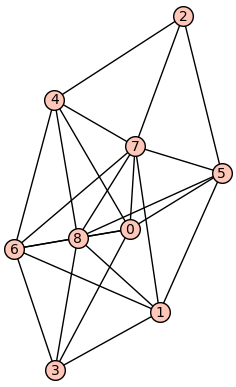

{0: [3, 4, 5, 6, 7, 8], 1: [3, 5, 6, 7, 8], 2: [4, 5, 7], 3: [0, 1, 6, 8], 4: [0, 2, 6, 7, 8], 5: [0, 1, 2, 7, 8], 6: [0, 1, 3, 4, 7, 8], 7: [0, 1, 2, 4, 5, 6, 8], 8: [0, 1, 3, 4, 5, 6, 7]}
Graphs corresponding to ('[0, -1, -2.873591723440327?, -1.528659192880060?, -1.185122437819415?, 0.5375558283421367?, 0.6829394176641857?, 1.723206359400960?, 3.643671748732519?]', '[0, 0.7548537470687552?, 1.860602153821970?, 2.67897399533471?, 3.31480082932826?, 4.5506908062919?, 4.7571956977229?, 5.1853387345261?, 6.89754403590554?]')
[Graph on 9 vertices]


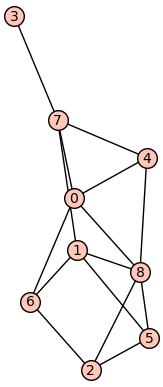

{0: [4, 6, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6, 8], 3: [7], 4: [0, 7, 8], 5: [1, 2, 8], 6: [0, 1, 2], 7: [0, 1, 3, 4], 8: [0, 1, 2, 4, 5]}


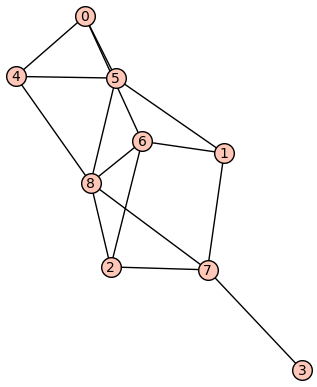

{0: [4, 5, 6], 1: [5, 6, 7], 2: [6, 7, 8], 3: [7], 4: [0, 5, 8], 5: [0, 1, 4, 8], 6: [0, 1, 2, 8], 7: [1, 2, 3, 8], 8: [2, 4, 5, 6, 7]}
Graphs corresponding to ('[0, -3.259670340402616?, -1.716854886914198?, -0.9311405464714926?, -0.7112343454458699?, 0.5547714404710496?, 0.8459404503491931?, 1.123168347643391?, 4.095019880770542?]', '[4, 0, 0.8887398332724067?, 2.669119177952930?, 3.18052298293164?, 4.68960614888570?, 5.17014545864111?, 5.85169927868922?, 7.550167119627000?]')
[Graph on 9 vertices]


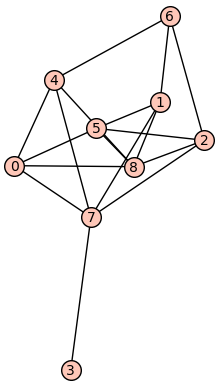

{0: [4, 5, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6, 7, 8], 3: [7], 4: [0, 6, 7, 8], 5: [0, 1, 2, 8], 6: [1, 2, 4], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 4, 5]}


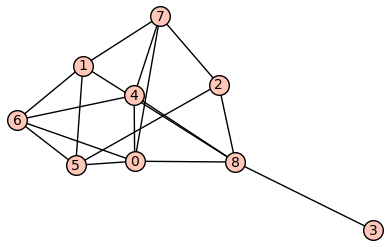

{0: [4, 5, 6, 7, 8], 1: [5, 6, 7, 8], 2: [5, 7, 8], 3: [8], 4: [0, 6, 7, 8], 5: [0, 1, 2, 6], 6: [0, 1, 4, 5], 7: [0, 1, 2, 4], 8: [0, 1, 2, 3, 4]}
Graphs corresponding to ('[-1, -2.818728328909852?, -1.772115792437058?, -1.408920848920624?, -0.1194218784029252?, 0.3859185119289372?, 1.139644055067183?, 1.243908616779098?, 4.349715664895241?]', '[6, 0, 1.478956307859600?, 2.494227969589440?, 3.22551151857428?, 4.16022124804575?, 5.16104880592513?, 6.29952611810889?, 7.18050803189692?]')
[Graph on 9 vertices]


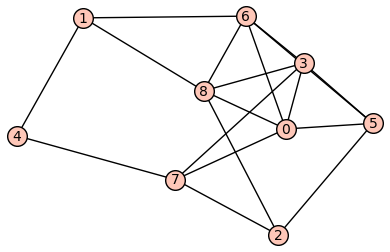

{0: [3, 5, 6, 7, 8], 1: [4, 6, 8], 2: [5, 7, 8], 3: [0, 5, 6, 7, 8], 4: [1, 7], 5: [0, 2, 3, 6], 6: [0, 1, 3, 5, 8], 7: [0, 2, 3, 4], 8: [0, 1, 2, 3, 6]}


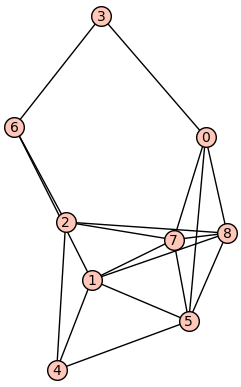

{0: [3, 5, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 6, 7, 8], 3: [0, 6], 4: [1, 2, 5], 5: [0, 1, 4, 7, 8], 6: [1, 2, 3], 7: [0, 1, 2, 5, 8], 8: [0, 1, 2, 5, 7]}
Graphs corresponding to ('[0, -1, -2.495487089337471?, -1.740277961628989?, -0.8191756637831232?, 0.5829133750660342?, 0.7802691885403304?, 1.598208442452235?, 3.093549708690984?]', '[1, 0, 0.6855534113201494?, 1.332016509531840?, 2.057043933271716?, 3.419307108868402?, 4.39247533470352?, 4.61268202335531?, 6.500921678949067? + 0.?e-73*I]')
[Graph on 9 vertices]


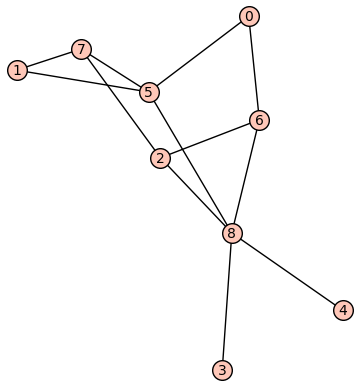

{0: [5, 6], 1: [5, 7], 2: [6, 7, 8], 3: [8], 4: [8], 5: [0, 1, 7, 8], 6: [0, 2, 8], 7: [1, 2, 5], 8: [2, 3, 4, 5, 6]}


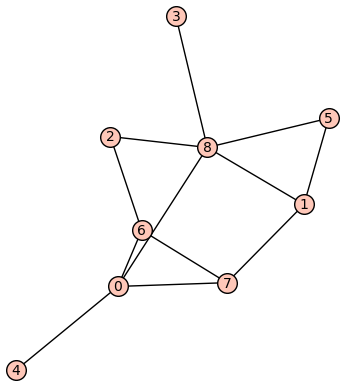

{0: [4, 6, 7, 8], 1: [5, 7, 8], 2: [6, 8], 3: [8], 4: [0], 5: [1, 8], 6: [0, 2, 7], 7: [0, 1, 6], 8: [0, 1, 2, 3, 5]}
Graphs corresponding to ('[0, -1, -1.618033988749895?, 0.618033988749895?, -2.294288443756717?, -1.174476900619234?, 0.521153740607135?, 1.823493171477502?, 3.124118432291315?]', '[1, 0, 0.4753097045136848?, 1.632337952348278?, 1.891220797748179?, 3.78961619537634?, 4.60096633859005?, 4.7090865868154?, 5.90146242460817?]')
[Graph on 9 vertices]


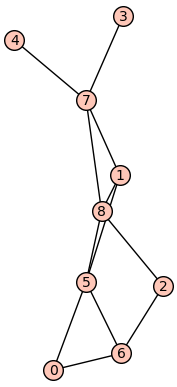

{0: [5, 6], 1: [5, 7, 8], 2: [6, 8], 3: [7], 4: [7], 5: [0, 1, 6, 8], 6: [0, 2, 5], 7: [1, 3, 4, 8], 8: [1, 2, 5, 7]}


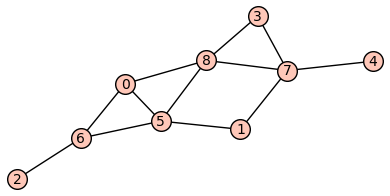

{0: [5, 6, 8], 1: [5, 7], 2: [6], 3: [7, 8], 4: [7], 5: [0, 1, 6, 8], 6: [0, 2, 5], 7: [1, 3, 4, 8], 8: [0, 3, 5, 7]}
Graphs corresponding to ('[-2.404143483786677?, -1.879286513580494?, -1.398164228932103?, -0.6970384271273051?, -0.1942713762989383?, 0.4892275625903117?, 0.7154945891551944?, 1.959541179142853?, 3.408640698837158?]', '[0, 0.798129872472630?, 1.328571069997625?, 2.256275592937199?, 2.93359969085935?, 4.5747437759943?, 5.27902136650770?, 6.52478442340024?, 4.3048742078310? + 0.?e-39*I]')
[Graph on 9 vertices]


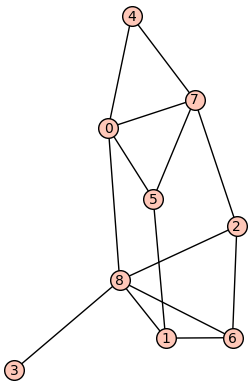

{0: [4, 5, 7, 8], 1: [5, 6, 8], 2: [6, 7, 8], 3: [8], 4: [0, 7], 5: [0, 1, 7], 6: [1, 2, 8], 7: [0, 2, 4, 5], 8: [0, 1, 2, 3, 6]}


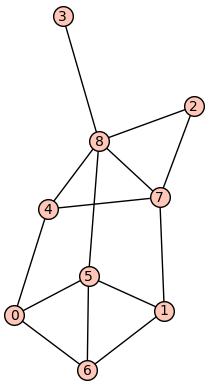

{0: [4, 5, 6], 1: [5, 6, 7], 2: [7, 8], 3: [8], 4: [0, 7, 8], 5: [0, 1, 6, 8], 6: [0, 1, 5], 7: [1, 2, 4, 8], 8: [2, 3, 4, 5, 7]}
Graphs corresponding to ('[0, 0, 0, -2.635051974545079?, -2.024963819207573?, -0.7430904560117089?, 0.8079953511918298?, 1.525072237852827?, 3.070038660719705?]', '[2, 0, 0.6865349422110930?, 0.9772357174589962?, 2.345608190962301?, 2.772175298368136?, 3.566013461803797?, 5.201394558809044?, 6.451037830386634?]')
[Graph on 9 vertices]


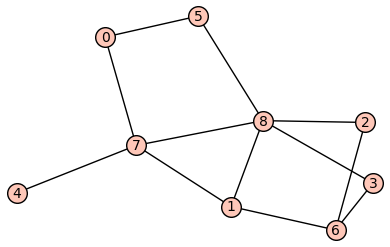

{0: [5, 7], 1: [6, 7, 8], 2: [6, 8], 3: [6, 8], 4: [7], 5: [0, 8], 6: [1, 2, 3], 7: [0, 1, 4, 8], 8: [1, 2, 3, 5, 7]}


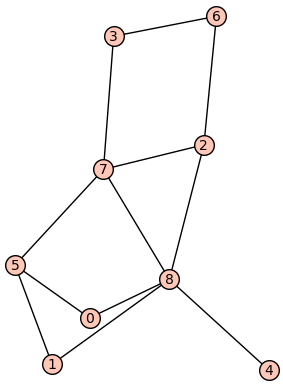

{0: [5, 8], 1: [5, 8], 2: [6, 7, 8], 3: [6, 7], 4: [8], 5: [0, 1, 7], 6: [2, 3], 7: [2, 3, 5, 8], 8: [0, 1, 2, 4, 7]}
Graphs corresponding to ('[0, -2.673334226761809?, -1.571163284698088?, -1.509868349102182?, -0.6985895030406283?, 0.1863572315358980?, 0.6948526571023313?, 1.897819454244121?, 3.673926020720356?]', '[0, 0.8165356798950580?, 1.354891609398214?, 2.89365784225244?, 3.31011328091159?, 4.3265402354856?, 5.1318542890673?, 5.3409693012597?, 6.825437761730191?]')
[Graph on 9 vertices]


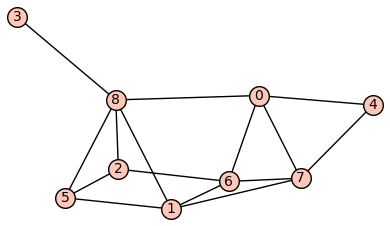

{0: [4, 6, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6, 8], 3: [8], 4: [0, 7], 5: [1, 2, 8], 6: [0, 1, 2, 7], 7: [0, 1, 4, 6], 8: [0, 1, 2, 3, 5]}


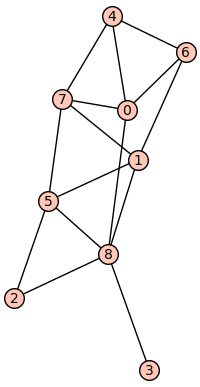

{0: [4, 6, 7, 8], 1: [5, 6, 7, 8], 2: [5, 8], 3: [8], 4: [0, 6, 7], 5: [1, 2, 7, 8], 6: [0, 1, 4], 7: [0, 1, 4, 5], 8: [0, 1, 2, 3, 5]}
Graphs corresponding to ('[0, -2.938837682070191?, -1.708112656539407?, -1.235160635048885?, -0.8133622610303504?, 0.5108896637464803?, 0.801389350400423?, 1.494563041943081?, 3.888631178598849?]', '[0, 0.783226745397534?, 2.41839806316788?, 2.78265478246650?, 3.58019455285113?, 4.5997337764721?, 5.0953690163295?, 5.7796948699143?, 6.96072819340113?]')
[Graph on 9 vertices]


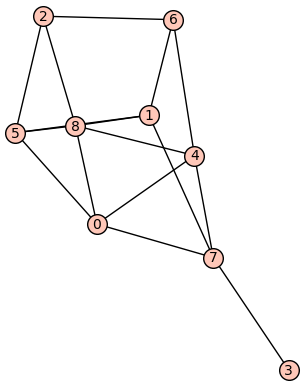

{0: [4, 5, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6, 8], 3: [7], 4: [0, 6, 7, 8], 5: [0, 1, 2, 8], 6: [1, 2, 4], 7: [0, 1, 3, 4], 8: [0, 1, 2, 4, 5]}


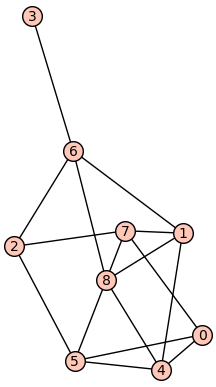

{0: [4, 5, 7], 1: [4, 6, 7, 8], 2: [5, 6, 7], 3: [6], 4: [0, 1, 5, 8], 5: [0, 2, 4, 8], 6: [1, 2, 3, 8], 7: [0, 1, 2, 8], 8: [1, 4, 5, 6, 7]}
Graphs corresponding to ('[0, -1.414213562373095?, 1.414213562373095?, -2.853096369424710?, -1.844986361829952?, -1.093287048854738?, -0.4319189515553128?, 0.908308876092041?, 5.314979855572671?]', '[5, 0, 2.548962169613366?, 3.798605441190957?, 5.4339865381962?, 6.2278247016319?, 6.6543918090377?, 8.0227642825410?, 8.3134650577889?]')
[Graph on 9 vertices]


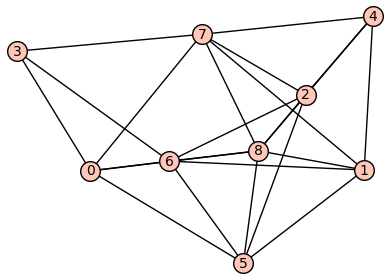

{0: [3, 5, 6, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 5, 6, 7, 8], 3: [0, 6, 7], 4: [1, 2, 7, 8], 5: [0, 1, 2, 6, 8], 6: [0, 1, 2, 3, 5, 8], 7: [0, 1, 2, 3, 4, 8], 8: [0, 1, 2, 4, 5, 6, 7]}


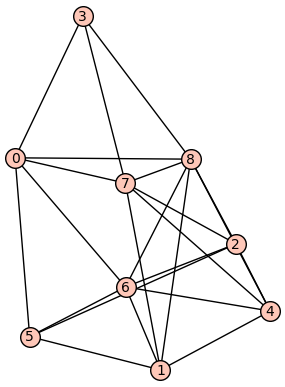

{0: [3, 5, 6, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 5, 6, 7, 8], 3: [0, 7, 8], 4: [1, 2, 6, 7, 8], 5: [0, 1, 2, 6], 6: [0, 1, 2, 4, 5, 8], 7: [0, 1, 2, 3, 4, 8], 8: [0, 1, 2, 3, 4, 6, 7]}
Graphs corresponding to ('[0, -2.772402693499080?, -1.809978877295812?, -1.545755942670245?, -0.616406682933096?, 0.1862215819901410?, 0.7360956924672924?, 1.371184465139233?, 4.451042456801564?]', '[0, 0.8813085721323857?, 3.37066394072710?, 4.1606608464401?, 4.8505277495014?, 6.2349929379410?, 6.5370467970920?, 2.358807308248040? + 0.?e-57*I, 7.60599184791824? + 0.?e-46*I]')
[Graph on 9 vertices]


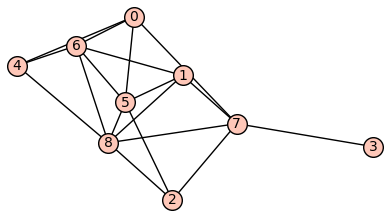

{0: [4, 5, 6, 7], 1: [5, 6, 7, 8], 2: [5, 7, 8], 3: [7], 4: [0, 6, 8], 5: [0, 1, 2, 6, 8], 6: [0, 1, 4, 5, 8], 7: [0, 1, 2, 3, 8], 8: [1, 2, 4, 5, 6, 7]}


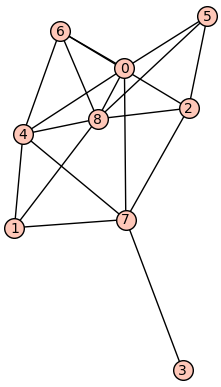

{0: [4, 5, 6, 7, 8], 1: [4, 7, 8], 2: [5, 6, 7, 8], 3: [7], 4: [0, 1, 6, 7, 8], 5: [0, 2, 8], 6: [0, 2, 4, 8], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 4, 5, 6]}
Graphs corresponding to ('[0, -3.282094944976394?, -1.728038672080419?, -1.518069474737164?, -0.7977172969027940?, 0.2765958916990123?, 0.8319363967998191?, 0.9634357376594422?, 5.253952362538497?]', '[5, 0, 3.56285918976786?, 3.8419483455838?, 4.4359505504478?, 6.1039263352566?, 6.7930602317422?, 7.7892567106473?, 8.47299863655461?]')
[Graph on 9 vertices]


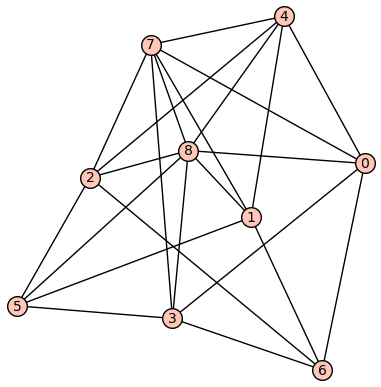

{0: [3, 4, 6, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 5, 6, 7, 8], 3: [0, 5, 6, 7, 8], 4: [0, 1, 2, 7, 8], 5: [1, 2, 3, 8], 6: [0, 1, 2, 3], 7: [0, 1, 2, 3, 4, 8], 8: [0, 1, 2, 3, 4, 5, 7]}


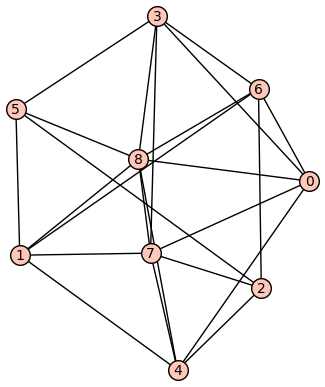

{0: [3, 4, 6, 7, 8], 1: [4, 5, 6, 7, 8], 2: [4, 5, 6, 7], 3: [0, 5, 6, 7, 8], 4: [0, 1, 2, 7, 8], 5: [1, 2, 3, 8], 6: [0, 1, 2, 3, 8], 7: [0, 1, 2, 3, 4, 8], 8: [0, 1, 3, 4, 5, 6, 7]}
done


In [23]:
#Searching for laplacian and adjacency cospectral graphs

Graph_List = graphs.nauty_geng("9")
spec_set = set()
spec_dict = {}

for G in Graph_List:
    spectrum = (str(G.adjacency_matrix().eigenvalues()),str(G.kirchhoff_matrix().eigenvalues()))
    if spectrum in spec_dict:
        spec_set.add(spectrum)
        spec_dict[spectrum].append(G)
    else:
        spec_dict.update({spectrum: [G]})


for cospectrum in spec_set:
    print("Graphs corresponding to " + str(cospectrum))
    print(spec_dict[spectrum])
    for G in spec_dict[cospectrum]:
        G.show()
        print(G.to_dictionary())        
print("done")

41
Not Ihara Cospectral
Not Ihara Cospectral
Not Ihara Cospectral
Ihara cospectral


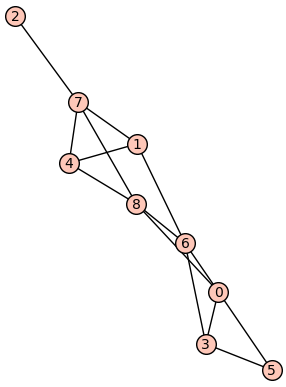

{0: [3, 5, 6, 8], 1: [4, 6, 7], 2: [7], 3: [0, 5, 6], 4: [1, 7, 8], 5: [0, 3], 6: [0, 1, 3, 8], 7: [1, 2, 4, 8], 8: [0, 4, 6, 7]}


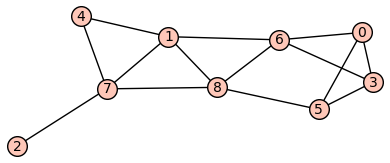

{0: [3, 5, 6], 1: [4, 6, 7, 8], 2: [7], 3: [0, 5, 6], 4: [1, 7], 5: [0, 3, 8], 6: [0, 1, 3, 8], 7: [1, 2, 4, 8], 8: [1, 5, 6, 7]}

Not Ihara Cospectral
Not Ihara Cospectral
Not Ihara Cospectral
Not Ihara Cospectral
Ihara cospectral


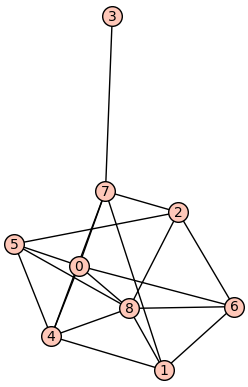

{0: [4, 5, 6, 7, 8], 1: [4, 6, 7, 8], 2: [5, 6, 7, 8], 3: [7], 4: [0, 1, 5, 7, 8], 5: [0, 2, 4, 8], 6: [0, 1, 2, 8], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 4, 5, 6]}


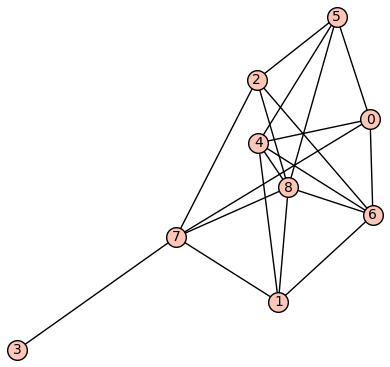

{0: [4, 5, 6, 7], 1: [4, 6, 7, 8], 2: [5, 6, 7, 8], 3: [7], 4: [0, 1, 5, 6, 8], 5: [0, 2, 4, 8], 6: [0, 1, 2, 4, 8], 7: [0, 1, 2, 3, 8], 8: [1, 2, 4, 5, 6, 7]}

Not Ihara Cospectral
Not Ihara Cospectral
Not Ihara Cospectral
Ihara cospectral


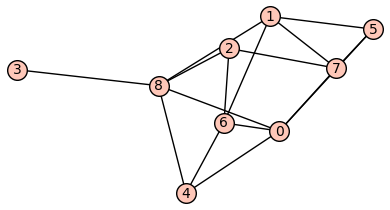

{0: [4, 5, 6, 7, 8], 1: [5, 6, 7, 8], 2: [6, 7, 8], 3: [8], 4: [0, 6, 8], 5: [0, 1, 7], 6: [0, 1, 2, 4], 7: [0, 1, 2, 5], 8: [0, 1, 2, 3, 4]}


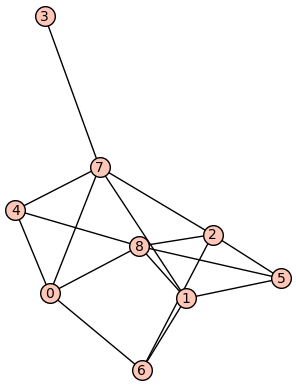

{0: [4, 6, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6, 7, 8], 3: [7], 4: [0, 7, 8], 5: [1, 2, 8], 6: [0, 1, 2], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 4, 5]}

Ihara cospectral


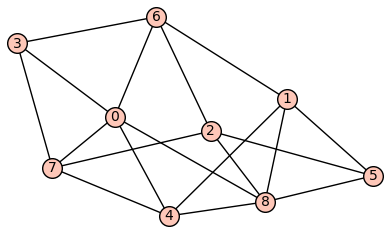

{0: [3, 4, 6, 7, 8], 1: [4, 5, 6, 8], 2: [5, 6, 7, 8], 3: [0, 6, 7], 4: [0, 1, 7, 8], 5: [1, 2, 8], 6: [0, 1, 2, 3], 7: [0, 2, 3, 4], 8: [0, 1, 2, 4, 5]}


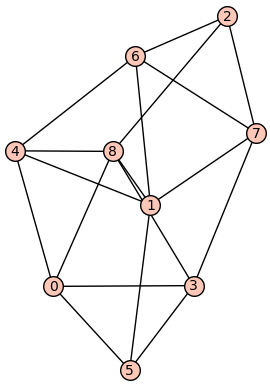

{0: [3, 4, 5, 8], 1: [4, 5, 6, 7, 8], 2: [6, 7, 8], 3: [0, 5, 7, 8], 4: [0, 1, 6, 8], 5: [0, 1, 3], 6: [1, 2, 4, 7], 7: [1, 2, 3, 6], 8: [0, 1, 2, 3, 4]}

Not Ihara Cospectral
Not Ihara Cospectral
Not Ihara Cospectral
Not Ihara Cospectral
Ihara cospectral


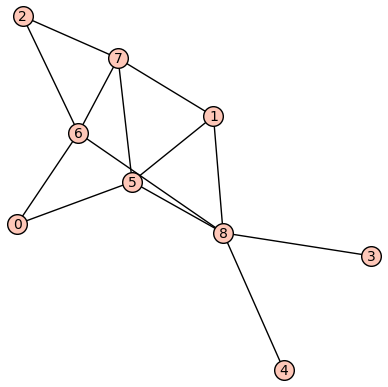

{0: [5, 6], 1: [5, 7, 8], 2: [6, 7], 3: [8], 4: [8], 5: [0, 1, 7, 8], 6: [0, 2, 7, 8], 7: [1, 2, 5, 6], 8: [1, 3, 4, 5, 6]}


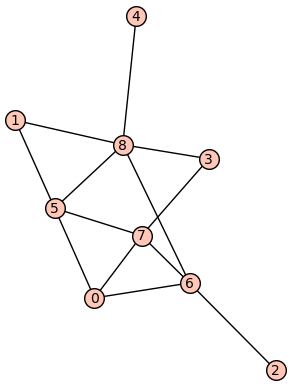

{0: [5, 6, 7], 1: [5, 8], 2: [6], 3: [7, 8], 4: [8], 5: [0, 1, 7, 8], 6: [0, 2, 7, 8], 7: [0, 3, 5, 6], 8: [1, 3, 4, 5, 6]}

Not Ihara Cospectral
Ihara cospectral


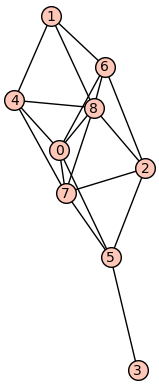

{0: [4, 5, 6, 7, 8], 1: [4, 6, 8], 2: [5, 6, 7, 8], 3: [5], 4: [0, 1, 7, 8], 5: [0, 2, 3, 7], 6: [0, 1, 2, 8], 7: [0, 2, 4, 5, 8], 8: [0, 1, 2, 4, 6, 7]}


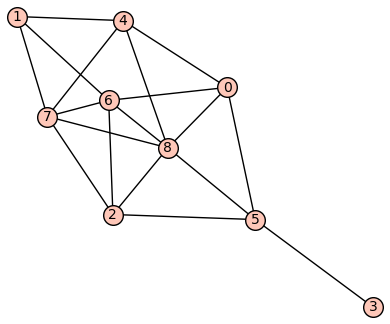

{0: [4, 5, 6, 8], 1: [4, 6, 7], 2: [5, 6, 7, 8], 3: [5], 4: [0, 1, 7, 8], 5: [0, 2, 3, 8], 6: [0, 1, 2, 7, 8], 7: [1, 2, 4, 6, 8], 8: [0, 2, 4, 5, 6, 7]}

Not Ihara Cospectral
Not Ihara Cospectral
Not Ihara Cospectral
Ihara cospectral


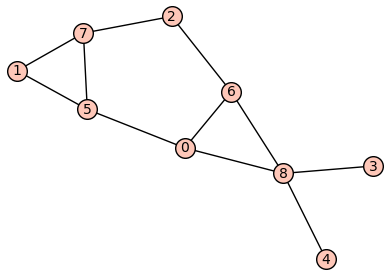

{0: [5, 6, 8], 1: [5, 7], 2: [6, 7], 3: [8], 4: [8], 5: [0, 1, 7], 6: [0, 2, 8], 7: [1, 2, 5], 8: [0, 3, 4, 6]}


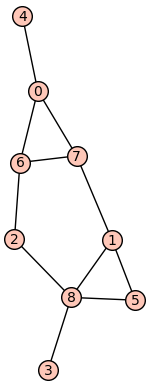

{0: [4, 6, 7], 1: [5, 7, 8], 2: [6, 8], 3: [8], 4: [0], 5: [1, 8], 6: [0, 2, 7], 7: [0, 1, 6], 8: [1, 2, 3, 5]}

Not Ihara Cospectral
Ihara cospectral


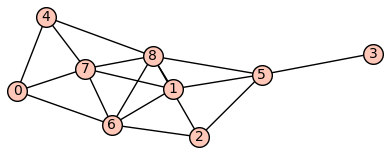

{0: [4, 6, 7], 1: [5, 6, 7, 8], 2: [5, 6, 8], 3: [5], 4: [0, 7, 8], 5: [1, 2, 3, 8], 6: [0, 1, 2, 7, 8], 7: [0, 1, 4, 6, 8], 8: [1, 2, 4, 5, 6, 7]}


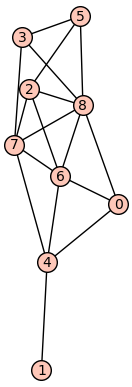

{0: [4, 6, 8], 1: [4], 2: [5, 6, 7, 8], 3: [5, 7, 8], 4: [0, 1, 6, 7], 5: [2, 3, 8], 6: [0, 2, 4, 7, 8], 7: [2, 3, 4, 6, 8], 8: [0, 2, 3, 5, 6, 7]}

Ihara cospectral


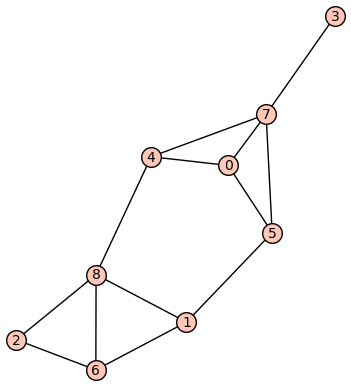

{0: [4, 5, 7], 1: [5, 6, 8], 2: [6, 8], 3: [7], 4: [0, 7, 8], 5: [0, 1, 7], 6: [1, 2, 8], 7: [0, 3, 4, 5], 8: [1, 2, 4, 6]}


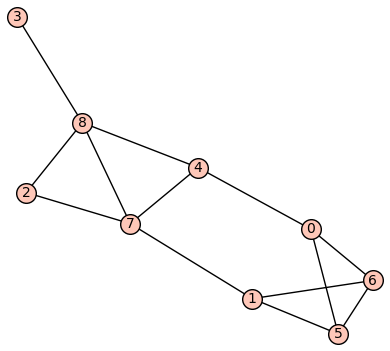

{0: [4, 5, 6], 1: [5, 6, 7], 2: [7, 8], 3: [8], 4: [0, 7, 8], 5: [0, 1, 6], 6: [0, 1, 5], 7: [1, 2, 4, 8], 8: [2, 3, 4, 7]}

Not Ihara Cospectral
Ihara cospectral


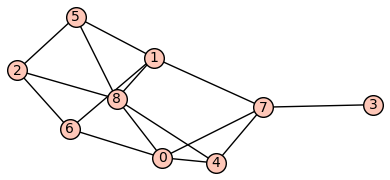

{0: [4, 6, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6, 8], 3: [7], 4: [0, 7, 8], 5: [1, 2, 8], 6: [0, 1, 2], 7: [0, 1, 3, 4], 8: [0, 1, 2, 4, 5]}


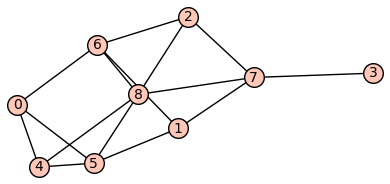

{0: [4, 5, 6], 1: [5, 6, 7], 2: [6, 7, 8], 3: [7], 4: [0, 5, 8], 5: [0, 1, 4, 8], 6: [0, 1, 2, 8], 7: [1, 2, 3, 8], 8: [2, 4, 5, 6, 7]}

Ihara cospectral


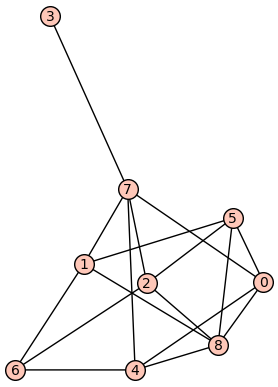

{0: [4, 5, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6, 7, 8], 3: [7], 4: [0, 6, 7, 8], 5: [0, 1, 2, 8], 6: [1, 2, 4], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 4, 5]}


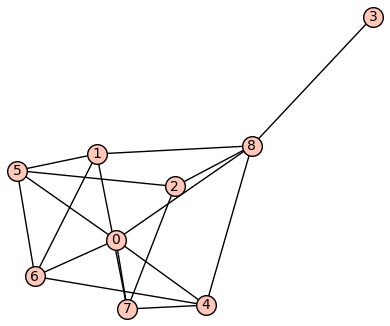

{0: [4, 5, 6, 7, 8], 1: [5, 6, 7, 8], 2: [5, 7, 8], 3: [8], 4: [0, 6, 7, 8], 5: [0, 1, 2, 6], 6: [0, 1, 4, 5], 7: [0, 1, 2, 4], 8: [0, 1, 2, 3, 4]}

Not Ihara Cospectral
Ihara cospectral


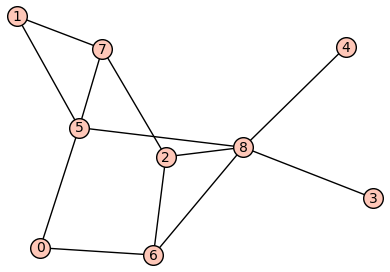

{0: [5, 6], 1: [5, 7], 2: [6, 7, 8], 3: [8], 4: [8], 5: [0, 1, 7, 8], 6: [0, 2, 8], 7: [1, 2, 5], 8: [2, 3, 4, 5, 6]}


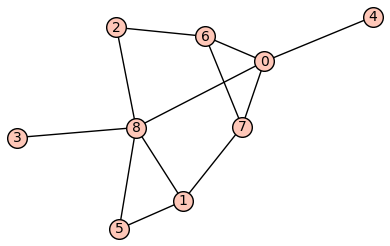

{0: [4, 6, 7, 8], 1: [5, 7, 8], 2: [6, 8], 3: [8], 4: [0], 5: [1, 8], 6: [0, 2, 7], 7: [0, 1, 6], 8: [0, 1, 2, 3, 5]}

Ihara cospectral


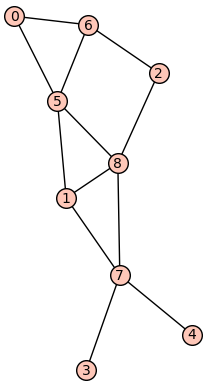

{0: [5, 6], 1: [5, 7, 8], 2: [6, 8], 3: [7], 4: [7], 5: [0, 1, 6, 8], 6: [0, 2, 5], 7: [1, 3, 4, 8], 8: [1, 2, 5, 7]}


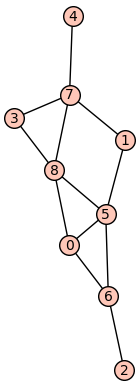

{0: [5, 6, 8], 1: [5, 7], 2: [6], 3: [7, 8], 4: [7], 5: [0, 1, 6, 8], 6: [0, 2, 5], 7: [1, 3, 4, 8], 8: [0, 3, 5, 7]}

Ihara cospectral


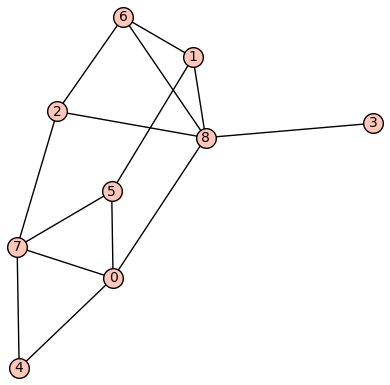

{0: [4, 5, 7, 8], 1: [5, 6, 8], 2: [6, 7, 8], 3: [8], 4: [0, 7], 5: [0, 1, 7], 6: [1, 2, 8], 7: [0, 2, 4, 5], 8: [0, 1, 2, 3, 6]}


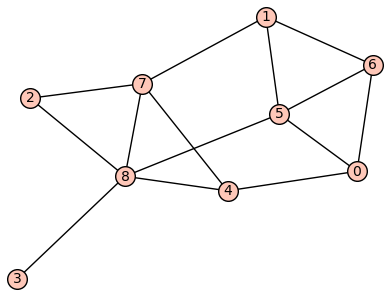

{0: [4, 5, 6], 1: [5, 6, 7], 2: [7, 8], 3: [8], 4: [0, 7, 8], 5: [0, 1, 6, 8], 6: [0, 1, 5], 7: [1, 2, 4, 8], 8: [2, 3, 4, 5, 7]}

Not Ihara Cospectral
Ihara cospectral


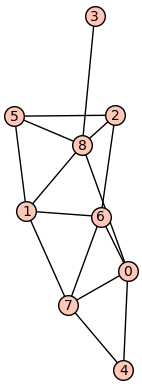

{0: [4, 6, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6, 8], 3: [8], 4: [0, 7], 5: [1, 2, 8], 6: [0, 1, 2, 7], 7: [0, 1, 4, 6], 8: [0, 1, 2, 3, 5]}


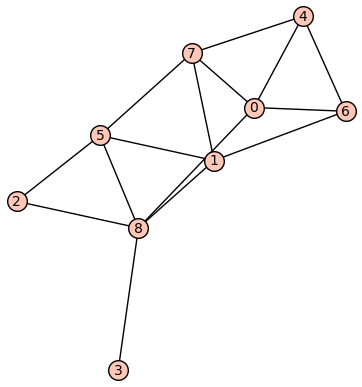

{0: [4, 6, 7, 8], 1: [5, 6, 7, 8], 2: [5, 8], 3: [8], 4: [0, 6, 7], 5: [1, 2, 7, 8], 6: [0, 1, 4], 7: [0, 1, 4, 5], 8: [0, 1, 2, 3, 5]}

Ihara cospectral


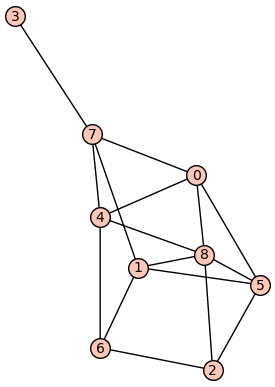

{0: [4, 5, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6, 8], 3: [7], 4: [0, 6, 7, 8], 5: [0, 1, 2, 8], 6: [1, 2, 4], 7: [0, 1, 3, 4], 8: [0, 1, 2, 4, 5]}


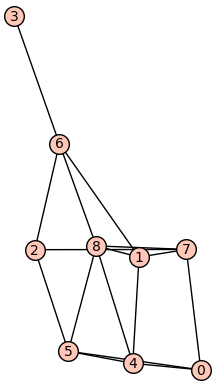

{0: [4, 5, 7], 1: [4, 6, 7, 8], 2: [5, 6, 7], 3: [6], 4: [0, 1, 5, 8], 5: [0, 2, 4, 8], 6: [1, 2, 3, 8], 7: [0, 1, 2, 8], 8: [1, 4, 5, 6, 7]}

Not Ihara Cospectral
Ihara cospectral


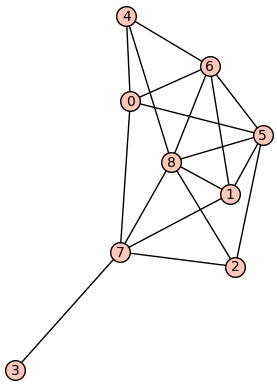

{0: [4, 5, 6, 7], 1: [5, 6, 7, 8], 2: [5, 7, 8], 3: [7], 4: [0, 6, 8], 5: [0, 1, 2, 6, 8], 6: [0, 1, 4, 5, 8], 7: [0, 1, 2, 3, 8], 8: [1, 2, 4, 5, 6, 7]}


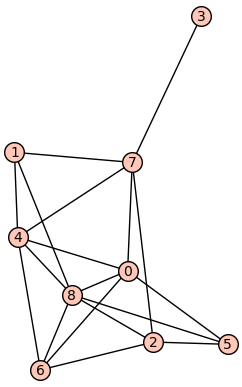

{0: [4, 5, 6, 7, 8], 1: [4, 7, 8], 2: [5, 6, 7, 8], 3: [7], 4: [0, 1, 6, 7, 8], 5: [0, 2, 8], 6: [0, 2, 4, 8], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 4, 5, 6]}

Not Ihara Cospectral
done


In [27]:
#Checking which ones are ihara cospectral

print(len(spec_set))
for cospectrum in spec_set:
    g1 = spec_dict[cospectrum][0]
    g2 = spec_dict[cospectrum][1]
    
    if ihara_matrix(g1).eigenvalues() == ihara_matrix(g2).eigenvalues():
        print("Ihara cospectral")
        show(g1)
        print(g1.to_dictionary())
        show(g2)
        print(g2.to_dictionary())
        print()
    else:
        print("Not Ihara Cospectral")
print("done")

In [34]:
#all of them have the same degree sequence

print(len(spec_set))
for cospectrum in spec_set:
    g1 = spec_dict[cospectrum][0]
    g2 = spec_dict[cospectrum][1]
    
    if g1.degree_sequence() == g2.degree_sequence():
        print("Same degree sequence")
    else:
        show(g1)
        print(g1.to_dictionary())
        show(g2)
        print(g2.to_dictionary())
        print()
print("done")

41
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
Same degree sequence
done


In [36]:
#attempt to find the sim

for cospectrum in spec_set:
    g1 = spec_dict[cospectrum][0].adjacency_matrix()
    g2 = spec_dict[cospectrum][1].adjacency_matrix()
    
    T = g1.diagonalization()[1]
    T = T.change_ring(ComplexField(50))
    T_inverse = T.inverse()

    Q = g2.diagonalization()[1]
    Q = Q.change_ring(ComplexField(50))
    Q_inverse = Q.inverse()
    
    print(g1)
    print(Q*T*g1*T_inverse*Q_inverse)

ValueError: matrix entries must be from a field

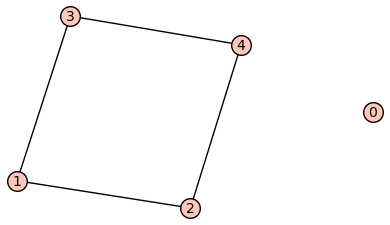

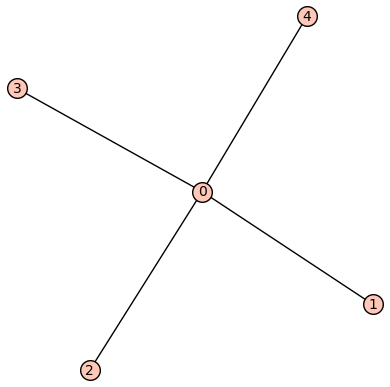

[2, -2, 0, 0, 0]


In [33]:
g1 = Graph({0:[],1:[2,3], 4:[2,3]})
g2 = Graph({0:[1,2,3,4]})
show(g1)
show(g2)
if g1.spectrum() == g2.spectrum():
    print(g1.adjacency_matrix().eigenvalues())

In [ ]:
#1
g1 = {0: [4, 5, 6, 7, 8], 1: [5, 6, 7, 8], 2: [6, 7, 8], 3: [8], 4: [0, 6, 8], 5: [0, 1, 7], 6: [0, 1, 2, 4], 7: [0, 1, 2, 5], 8: [0, 1, 2, 3, 4]}
g2 = {0: [4, 6, 7, 8], 1: [5, 6, 7, 8], 2: [5, 6, 7, 8], 3: [7], 4: [0, 7, 8], 5: [1, 2, 8], 6: [0, 1, 2], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 4, 5]}
g1 = Graph(g1)
g2 = Graph(g2)
if g1.degree_sequence() == g2.degree_sequence():
    print("1 True")
else:
    print("1 False")
    
#2
g1 = {0: [4, 6, 7, 8], 1: [5, 6, 8], 2: [5, 7, 8], 3: [5, 7, 8], 4: [0, 6, 8], 5: [1, 2, 3, 7, 8], 6: [0, 1, 4, 7], 7: [0, 2, 3, 5, 6], 8: [0, 1, 2, 3, 4, 5]}
g2 = {0: [4, 5, 6, 7], 1: [5, 7, 8], 2: [6, 7, 8], 3: [6, 7, 8], 4: [0, 5, 8], 5: [0, 1, 4, 8], 6: [0, 2, 3, 7, 8], 7: [0, 1, 2, 3, 6], 8: [1, 2, 3, 4, 5, 6]}
g1 = Graph(g1)
g2 = Graph(g2)
if g1.degree_sequence() == g2.degree_sequence():
    print("2 True")
else:
    print("2 False")
    
#3
g1 = {0: [3, 5, 6, 7], 1: [4, 6, 7, 8], 2: [5, 7, 8], 3: [0, 5, 8], 4: [1, 6, 7, 8], 5: [0, 2, 3, 8], 6: [0, 1, 4, 7, 8], 7: [0, 1, 2, 4, 6], 8: [1, 2, 3, 4, 5, 6]}
g2 = {0: [3, 5, 7, 8], 1: [4, 6, 7, 8], 2: [5, 6, 8], 3: [0, 5, 7, 8], 4: [1, 6, 8], 5: [0, 2, 3, 7, 8], 6: [1, 2, 4, 7], 7: [0, 1, 3, 5, 6], 8: [0, 1, 2, 3, 4, 5]}
g1 = Graph(g1)
g2 = Graph(g2)
if g1.degree_sequence() == g2.degree_sequence():
    print("3 True")
else:
    print("3 False")
    
#4
g1 = {0: [3, 4, 6, 8], 1: [5, 6, 7, 8], 2: [5, 7, 8], 3: [0, 4, 6, 8], 4: [0, 3, 7, 8], 5: [1, 2, 7], 6: [0, 1, 3, 8], 7: [1, 2, 4, 5, 8], 8: [0, 1, 2, 3, 4, 6, 7]}
g2 = {0: [3, 4, 6, 8], 1: [5, 6, 7, 8], 2: [5, 7, 8], 3: [0, 4, 6], 4: [0, 3, 7, 8], 5: [1, 2, 7, 8], 6: [0, 1, 3, 8], 7: [1, 2, 4, 5, 8], 8: [0, 1, 2, 4, 5, 6, 7]}

In [ ]:
# example of when NB cospectral but not Ihara Cospectral

g1 = {0:[1,2], 3:[1,2], 4:[2]}
g2 = {0:[1,2], 3:[1,2], 4:[5]}
g1 = Graph(g1)
g2 = Graph(g2)

show(g1)
show(g2)

show_cospectrality(g1,g2)

In [ ]:
#2nd cospectral set on 9 vertices 


g1 = {4: [0, 6, 8], 1: [5, 7], 2: [5, 7, 8], 3: [6, 7, 8], 0: [4, 6], 5: [1, 2, 7, 8], 6: [0, 3, 4, 8], 7: [1, 2, 3, 5], 8: [4, 2, 3, 5, 6]}
g1 = Graph(g1)
show(g1)
K1 = ihara_matrix(g1)
print('K1^7: ')
show(K1^7)
A1 = g1.adjacency_matrix()
B1 = edge_adjacency_nb_matrix(g1)
print('trace of B1^7: ')
show((B1^7).trace())
print('trace of K1^7 - K1^5 - K1^3: ')
show((K1^7 - K1^5 - K1^3).trace())
print('trace of A1^5: ')
show((A1^5).trace())

g2 = {0: [3, 5], 1: [7, 8], 2: [4, 6, 7], 3: [0, 5, 6], 4: [2, 7, 8], 5: [0, 3, 6, 8], 6: [2, 3, 5, 8], 7: [1, 2, 4, 8], 8: [1, 4, 5, 6, 7]}
g2 = Graph(g2)
show(g2)
K2 = ihara_matrix(g2)
print('K2^5: ')
show(K2^5)
A2 = g2.adjacency_matrix()
B2 = edge_adjacency_nb_matrix(g2)
print('trace of B2^5: ')
show((B2^5).trace())
print('trace of K2^5: ')
show((K2^5).trace())
print('trace of A2^3: ')
show((A2^3).trace())

#g1_adj = g1.adjacency_matrix()
#g2_adj = g2.adjacency_matrix()




"""

T = g1.diagonalization()[1]
T = T.change_ring(ComplexField(50))
T_inverse = T.inverse()

Q = g2.diagonalization()[1]
Q = Q.change_ring(ComplexField(50))
Q_inverse = Q.inverse()

S = T*Q_inverse


for x in range(18):
    for y in range(18):
        entry = S[x,y]
        if entry.real() < 10**(-5) and entry.real() > -10**(-5):
            S[x,y] = S[x,y].imag()*I
        if entry.imag() < 10**(-5) and entry.imag() > -10**(-5):
            S[x,y] = S[x,y].real()

#diag1 = diag1.n(digits = 1)


show(S)


S_inverse = Q*T_inverse

for x in range(18):
    for y in range(18):
        entry = S_inverse[x,y]
        if entry.real() < 10**(-5) and entry.real() > -(10**(-5)):
            S_inverse[x,y] = S_inverse[x,y].imag()*I
        if entry.imag() < 10**(-5) and entry.imag() > -(10**(-5)):
            S_inverse[x,y] = S_inverse[x,y].real()

#show(S_inverse)

S_11 = S.submatrix(0,0,9,9)

show(g1_adj*S_11 - S_11*g2_adj)
"""



"""
multiplying on the left by left eigenmatrix and the right by right eigenmatrix gives the diagonal matrix

try permuting the entries so that they line up

inverse function may need some sort of argument like numeric or something
"""


In [ ]:
#3rd cospectral set on 9 vertices


g1 = {0: [5,7], 1: [2,6], 2: [1, 6, 8], 3: [6, 7, 8], 4: [5, 7, 8], 5: [0, 4, 7, 8], 6: [1, 2, 3, 8], 7: [0, 3, 4, 5], 8: [2, 3, 4, 5, 6]}
g1 = Graph(g1)
g2 = {0: [3, 5], 1: [7, 8], 2: [4, 6, 7], 3: [0, 5, 6], 4: [2, 7, 8], 5: [0, 3, 6, 8], 6: [2, 3, 5, 8], 7: [1, 2, 4, 8], 8: [1, 4, 5, 6, 7]}
g2 = Graph(g2)

g1 = ihara_matrix(g1)
g2 = ihara_matrix(g2)



T = g1.diagonalization()[1]
T = T.change_ring(ComplexField(50))
T_inverse = T.inverse()

Q = g2.diagonalization()[1]
Q = Q.change_ring(ComplexField(50))
Q_inverse = Q.inverse()

S = T*Q_inverse


for x in range(18):
    for y in range(18):
        entry = S[x,y]
        if entry.real() < 10**(-5) and entry.real() > -10**(-5):
            S[x,y] = S[x,y].imag()*I
        if entry.imag() < 10**(-5) and entry.imag() > -10**(-5):
            S[x,y] = S[x,y].real()

#diag1 = diag1.n(digits = 1)


show(S)


S_inverse = Q*T_inverse

for x in range(18):
    for y in range(18):
        entry = S_inverse[x,y]
        if entry.real() < 10**(-5) and entry.real() > -(10**(-5)):
            S_inverse[x,y] = S_inverse[x,y].imag()*I
        if entry.imag() < 10**(-5) and entry.imag() > -(10**(-5)):
            S_inverse[x,y] = S_inverse[x,y].real()

#show(S_inverse)

In [ ]:
#1st NB-cospectral example on 8 vertices

g1 = {0: [4, 5], 1: [2, 3, 6], 2: [1, 3, 7], 3: [1, 2, 7], 4: [0, 5, 6, 7], 5: [0, 4, 6, 7], 6: [1, 4, 5, 7], 7: [2, 3, 4, 5, 6]}
g1 = Graph(g1)
g2 = {0: [3, 7], 1: [3, 6, 7], 2: [4, 5, 6], 3: [0, 1, 7], 4: [2, 5, 6, 7], 5: [2, 4, 6, 7], 6: [1, 2, 4, 5], 7: [0, 1, 3, 4, 5]}
g2 = Graph(g2)

#show_cospectrality(g1,g2)

g1_adj = g1.adjacency_matrix()
g2_adj = g2.adjacency_matrix()


g1 = ihara_matrix(g1)
g2 = ihara_matrix(g2)


#show(g1)
#show(g2)

T = g1.diagonalization()[1]
T = T.change_ring(ComplexField(50))
T_inverse = T.inverse()

Q = g2.diagonalization()[1]
Q = Q.change_ring(ComplexField(50))
Q_inverse = Q.inverse()

S = T*Q_inverse


for x in range(16):
    for y in range(16):
        entry = S[x,y]
        if entry.real() < 10**(-5) and entry.real() > -10**(-5):
            S[x,y] = S[x,y].imag()*I
        if entry.imag() < 10**(-5) and entry.imag() > -10**(-5):
            S[x,y] = S[x,y].real()

#diag1 = diag1.n(digits = 1)


show(16*S)


S_inverse = Q*T_inverse

for x in range(16):
    for y in range(16):
        entry = S_inverse[x,y]
        if entry.real() < 10**(-5) and entry.real() > -(10**(-5)):
            S_inverse[x,y] = S_inverse[x,y].imag()*I
        if entry.imag() < 10**(-5) and entry.imag() > -(10**(-5)):
            S_inverse[x,y] = S_inverse[x,y].real()

#show(S_inverse)


S_11 = 16*S.submatrix(0,0,8,8)

show(g1_adj*S_11 - S_11*g2_adj)

In [ ]:
a = matrix(RR, 3, [j * 100./99 for j in (23 .. 31)])
a.n(digits=7)

In [ ]:
g1 = Graph({0:[1,2],1:[3,4]})
g2 = Graph({4:[0,2],2:[1,3]})

g1 = g1.adjacency_matrix()
g2 = g2.adjacency_matrix()

found, similarity = g1.is_similar(g2,transformation=True)
print(similarity)

In [ ]:
Graph_List = graphs.nauty_geng("9 -c -d2")
print("finished")

In [ ]:
#Generated all-cospectral graphs using two graphs on 6 vertices

C = matrix([[0,0,0,0,0,0,0,0], [1,1,1,1,0,0,0,0], [0,0,0,0,1,1,1,1], [1,1,1,1,1,1,1,1], [0,0,0,1,1,0,0,0], [1,1,1,0,0,1,1,1]])
g1 = Graph({0:[1,5], 4:[5,3], 2:[1], 3:[5]})
g2 = Graph({5:[2,4], 3:[2,4], 1:[], 6:[7,0]})
graphs = special_GM_switch(g1,g2,C)

GM_g1 = graphs[0]
GM_g2 = graphs[1]
show(GM_g1,GM_g2)

show_cospectrality(GM_g1,GM_g2)

In [ ]:
#1st cospectral set on 9 vertices 

g1 = {0: [3, 4, 6, 7, 8], 1: [4, 5, 6, 8], 2: [5, 6, 7, 8], 3: [0, 6, 7], 4: [0, 1, 7, 8], 5: [1, 2, 8], 6: [0, 1, 2, 3], 7: [0, 2, 3, 4], 8: [0, 1, 2, 4, 5]}
g1 = Graph(g1)
g2 = {0: [3, 4, 5, 8], 1: [4, 5, 6, 7, 8], 2: [6, 7, 8], 3: [0, 5, 7, 8], 4: [0, 1, 6, 8], 5: [0, 1, 3], 6: [1, 2, 4, 7], 7: [1, 2, 3, 6], 8: [0, 1, 2, 3, 4]}
g2 = Graph(g2)

is_it_diagonalizable([g1,g2])
#print("is g2 diagonalizable?" + str(is_it_diagonalizable(g2)))


show_cospectrality(g1,g2)

#2nd cospectral set on 9 vertices

g1 = {0: [4, 6, 8], 1: [5, 7, 8], 2: [6, 7, 8], 3: [7, 8], 4: [0, 8], 5: [1, 7], 6: [0, 2], 7: [1, 2, 3, 5], 8: [0, 1, 2, 3, 4]}
g1 = Graph(g1)
g2 = {0: [4, 6, 7, 8], 1: [5, 7, 8], 2: [6, 8], 3: [7, 8], 4: [0, 6], 5: [1, 8], 6: [0, 2, 4], 7: [0, 1, 3], 8: [0, 1, 2, 3, 5]}
g2 = Graph(g2)


is_it_diagonalizable([g1,g2])

#print("is g1 diagonalizable?" + str(is_it_diagonalizable(g1)))
#print("is g2 diagonalizable?" + str(is_it_diagonalizable(g2)))

#g1 = edge_adjacency_nb_matrix(g1)
#g1 = DiGraph(g1)
#g2 = edge_adjacency_nb_matrix(g2)
#g2 = DiGraph(g2)

g1.show()
g2.show()

show_cospectrality(g1,g2)

deg_seq = False
if g1.degree_sequence() == g2.degree_sequence():
    deg_seq = True

print("degree sequences are equal: " + str(deg_seq))

#3rd cospectral set on 9 vertices

g1 = {0: [4, 6, 8], 1: [5, 7, 8], 2: [5, 7], 3: [6, 7, 8], 4: [0, 6], 5: [1, 2, 7, 8], 6: [0, 3, 4, 8], 7: [1, 2, 3, 5], 8: [0, 1, 3, 5, 6]}
g1 = Graph(g1)
g2 = {0: [3, 5, 6, 8], 1: [4, 6, 7], 2: [7, 8], 3: [0, 5, 6], 4: [1, 7, 8], 5: [0, 3], 6: [0, 1, 3, 8], 7: [1, 2, 4, 8], 8: [0, 2, 4, 6, 7]}
g2 = Graph(g2)

print(ihara_matrix(g1))
print()
print(ihara_matrix(g2))

is_it_diagonalizable([g1,g2])

#print("is g1 diagonalizable?" + str(is_it_diagonalizable(g1)))
#print("is g2 diagonalizable?" + str(is_it_diagonalizable(g2)))
  
show_cospectrality(g1,g2)

deg_seq = False
if g1.degree_sequence() == g2.degree_sequence():
    deg_seq = True

print("degree sequences are equal: " + str(deg_seq))

In [ ]:
"""
m = 6
d = 4
k = 4
C = zero_matrix(m,k)
C.set
print(C)
d_regular_graphs = graphs.nauty_geng(str(m) + " -c -d" + str(d) +" -D" + str(d))
d_regular_graphs_list = list(d_regular_graphs)
for graph in d_regular_graphs_list:
    show(graph)

all_graphs_order_k = graphs.nauty_geng(str(k) + "-c -d2")
all_graphs_order_k_list = list(all_graphs_order_k)
for graph in all_graphs_order_k_list:
    show(graph)

for g1 in d_regular_graphs_list:
    for g2 in all_graphs_order_k_list:
        pass


"""

In [ ]:
g1 = Graph({0:[4,1,2], 3:[1,2,5], 1:[2]})
g2 = Graph({0:[4,1,2], 3:[1,2], 1:[2,5]})

show(g1)
show(g2)

show_cospectrality(g1,g2)
print("graphs one and two are isomorphic: " + str(g1.is_isomorphic(g2)))


In [ ]:
g1 = Graph({1:[0,2,3], 2:[0,4], 3:[0,4,5], 4:[0,5], 5:[6]})
g2 = Graph({3:[0,2,4,5], 1:[2,0], 4:[0,5,6], 5:[0,6]})
show(g1)
show(g2)

show_cospectrality(g1,g2)

In [ ]:
C = matrix([[1,1,0,0], [1,0,1,0], [1,0,0,1], [0,1,0,1], [0,0,1,1], [0,1,1,0]])
g1 = Graph({0:[1,5], 4:[5,3], 2:[1,3]})
show(g1)
g2 = Graph({3:[2,1], 1:[0,2]})
show(g2)
graphs = GM_switch(g1,g2,C)

GM_g1 = graphs[0]
GM_g2 = graphs[1]
show(GM_g1,GM_g2)
show_cospectrality(GM_g1,GM_g2)

print(GM_g1.degree_sequence())
print(GM_g2.degree_sequence())

In [ ]:
#Generated all-cospectral graphs using two graphs on 4 vertices. Unfortunately, they are isomorphic


C = matrix([[1,1,0,0], [1,0,1,0], [0,1,0,1], [0,0,1,1]])

g1 = Graph({0:[1,3], 2:[1,3]})
g2 = Graph({0:[1,2], 2:[1,3]})

graphs = GM_switch(g1,g2,C)
for G in graphs:
    show(G)

g1 = graphs[0]
g2 = graphs[1]

print(g1.is_isomorphic(g2))

show_cospectrality(g1,g2)

In [ ]:
#Generated all-cospectral graphs using two graphs on 8 and 6 vertices


C = matrix([[1,1,1,0,0,0], [0,1,1,1,0,0], [0,0,1,1,1,0], [0,0,0,1,1,1], [1,0,0,0,1,1], [1,1,0,0,0,1], [1,0,1,0,0,1], [0,1,0,1,1,0]])
g1 = Graph({0:[1,7], 2:[1,3], 4:[3,5], 6:[5,7]})
#g2 = Graph({0:[1,2,3,4,5], 3:[1,2], 4:[5]})

g2_graphs = graphs.nauty_geng("6")

for g2 in g2_graphs:
    graphs = GM_switch(g1,g2,C)

    GM_g1 = graphs[0]
    GM_g2 = graphs[1]

    if ihara_cospectral(GM_g1,GM_g2) == False:
        show(GM_g1,GM_g2)

In [ ]:
"""two non-isomorphic graphs with same degree seq, ihara-cospectral, but not cospectral in regard to four matrices"""

g1 = {0:[6,7,9], 6:[3,1], 7:[3,1,5,4], 4:[1,5,2], 5:[1,2], 8:[1,4,5,7], 9:[0,3]}
g1 = Graph(g1)
show(g1)

g2 = {0:[3,4,6,7], 3:[4,6,7], 6:[4,1], 5:[1,2,7], 7:[1,2], 8:[0,3,4,6], 9:[2,7]}
g2 = Graph(g2)
show(g2)

show_cospectrality(g1,g2)

#g1_nb = edge_adjacency_nb_matrix(g1)
#g2_nb = edge_adjacency_nb_matrix(g2)

#g1_nb_graph = DiGraph(g1_nb)
#g2_nb_graph = DiGraph(g2_nb)



In [ ]:
# ANOTHER NON-REGULAR GRAPH WHICH IS COSPECTRAL IN REGARDS TO IHARA MATRIX WITH MIN DEGREE 2

#Example from paper Dr. Kempton sent us 

g1 = {0:[1,5,8,9], 1:[4,5,6], 2:[3,6,7,9], 3:[4,7,8], 5:[4,6]}
g2 = {0:[1,4,6,7], 1:[7,8,9], 2:[4,5,8,3], 3:[5,6,9], 5:[4,6]}

g1 = Graph(g1)
g2 = Graph(g2)

show(g1)
show(g2)

show_cospectrality(g1,g2)

In [ ]:
"""example of two adjacency-cospectral graphs with minimum degree at least 2"""

g1 = {0:[1,7,8], 1:[8,2], 3:[2,4], 5:[4,6], 7:[6,8], 8:[4]}
g1 = Graph(g1)
show(g1)
g2 = {0:[1,7,8], 1:[8,2], 3:[2,8,4], 5:[4,6], 7:[6], 8:[4]}
g2 = Graph(g2)
show(g2)

show_cospectrality(g1,g2)

In [ ]:
#reconstructing the counter-example to our conjecture about the diagonalizability of Ihara matrices


g = {0:[3,6,5], 1:[4,5,6], 2:[4,5,6], 3:[0,6], 4:[1,2,5], 5:[0,1,2,4,6], 6:[0,3,5]}
sad_graph = Graph(g)
show(sad_graph)
k_sad = ihara_matrix(sad_graph)
print("Is diagonalizable: " + str(k_sad.is_diagonalizable()))
print(k_sad.eigenvalues())

In [ ]:
#Testing several different graphs to see if they preserve their property of having an equitable partition


#G = Graph({})
#G.add_cycle([0,1,2,3])
#G.add_cycle([4,5,6,7])
#G.add_edges([(0,4),(1,5),(2,6),(3,7)])

G = graphs.CompleteBipartiteGraph(3,3)

G = DiGraph(edge_adjacency_nb_matrix(G))

print(G.is_equitable([[0,1],[2],[3,4]]))

#G = Graph({7:[0,1,3,5,6], 1:[0,2,3,5], 3:[2,4,5], 5:[4,6]})

#G = Graph({0:[1,2,3,6], 7:[1,4,5,6], 1:[2,4], 6:[3,5], 2:[3,4], 5:[3,4]})

#G = Graph({2:[0,1,3,4], 3:[1]})

show(G)
#print(G.adjacency_matrix())
#print()
#print(edge_adjacency_nb_matrix(G))

In [ ]:
#checking if nonbacktracking graph has an equitable partition

G = Graph({2:[0,1,3,4], 0:[1]})
#print(edge_adjacency_nb_matrix(G))
G = DiGraph(edge_adjacency_nb_matrix(G))
show(G)
print(G.coarsest_equitable_refinement([[0,2],[1,3],[4,5],[6,7],[8,9]]))
#G.is_equitable([[0,1],[2],[3,4]])
#G.is_equitable(P, quotient_matrix=True)

In [ ]:
#checking if nonbacktracking graph has an equitable partition

G = Graph({3:[4,2,5], 2:[0,5], 4:[1,5]})
print(edge_adjacency_nb_matrix(G))
G = DiGraph(edge_adjacency_nb_matrix(G))
show(G)
print(G.is_equitable([[0,1],[2,8],[12,7],[4,9],[13,5],[3,10],[6,11]], quotient_matrix = True))

In [ ]:
G = Graph({3:[0,1,2,4,5], 2:[0], 4:[1]})
print(edge_adjacency_nb_matrix(G))
G = DiGraph(edge_adjacency_nb_matrix(G))
show(G)
print(G.is_equitable([[0,4],[3,11],[10,13],[7,9],[6,8],[1,5],[2,12]], quotient_matrix = True))

In [ ]:
#An example of proposition 5.3 calculating the eigenvalues of the Ihara Matrix of some graph on 9 vertices

G = deg_two_graph(6,0.5)
G.add_vertices([6, 7, 8])
G.add_edges([(6,0),(7,0),(8,7)])
show(G)
K = ihara_matrix(G)
print("Ihara matrix is diagonalizable: " + str(K.is_diagonalizable()))
print(G.adjacency_matrix().eigenvalues())
compute_K_evals(G)

In [ ]:
"""testing cospectral 3-regular graphs on 16 vertices"""

g1 = {0:[1,3,7], 2:[3,1,4], 5:[4,6,7], 6:[4,8], 9:[8,7,11], 10:[3,8,12], 11:[1,15], 13:[12,14,15], 14:[12,15],}
g2 = {0:[1,6,9], 2:[1,3,4], 3:[4,11], 5:[4,6,7], 8:[6,7,10], 9:[11,12], 10:[1,15], 11:[7], 13:[12,14,15], 14:[12,15]}
g1 = Graph(g1)
g2 = Graph(g2)
show_cospectrality(g1,g2)

In [ ]:
#using cospectral_graphs() built in function to find cospectral graphs
gen = graphs.nauty_geng("12 -d3 -D3")
len(list(gen))
#g = graphs.cospectral_graphs(12, graphs=graphs.nauty_geng(12, -d3, -D3))

In [ ]:
g1 = {0:[2,3,4,5], 1:[2,3,4,5], 2:[3,6], 3:[4], 5:[4,7]}
g1 = Graph(g1)
show(g1)
g2 = {0:[2,3,4,5], 1:[2,3,4,5], 2:[3,6], 3:[4], 5:[4,7], 6:[7]}
g2 = Graph(g2)
show(g2)
print(g1.spectrum())
print(g2.spectrum())
are_cospectral(g1,g2)

In [ ]:
#These are two really big bi-regular graphs that are supposed to be cospectral. I screwed it up though

g1 = {0:[1,5,15], 1:[2,10], 2:[3,7], 3:[4,12], 4:[5,9], 6:[5,11,7], 8:[7,13,9], 10:[9,11], 12:[11,13], 14:[13,16,22], 16:[17,33], 17:[15,18], 18:[19,48], 19:[20,49], 20:[21,50], 21:[22,53], 23:[15,22,23], 24:[25,48], 25:[26,49], 26:[27,50], 27:[28,53], 28:[29,34], 29:[30,35], 30:[31,36], 31:[32,37], 32:[33,38], 33:[47], 34:[39,41], 35:[42,40], 36:[39,43], 37:[40,44], 38:[39,45], 47:[40,46], 41:[42,46], 43:[42,44], 45:[44,46], 51:[48,50,52], 52:[49,53]}
g1 = Graph(g1)
g2 = {0:[1,5,33], 1:[2,10], 2:[3,7], 3:[4,12], 4:[5,9], 6:[5,11,7], 8:[7,13,9], 10:[9,11], 12:[11,13], 13:[34], 15:[16,32,47], 16:[17,48], 17:[18,49], 18:[19,50], 19:[20,51], 20:[21,52], 21:[22,47], 22:[23,48], 23:[24,49], 24:[25,50], 25:[26,51], 26:[27,52], 27:[28,33], 28:[29,34], 29:[30,35], 30:[31,36], 31:[32,37], 32:[38], 41:[33,42,46], 42:[34,43], 43:[35,44], 44:[36,45], 45:[37,46], 46:[38], 39:[35,37,40], 40:[36,38], 53:[47,49,51], 54:[48,50,52]}
g2 = Graph(g2)
print(g1.adjacency_matrix().eigenvalues() == g2.adjacency_matrix().eigenvalues())